# Optimizing Deep Q Learning with SHAP Explanations
Exploring Minimum Experience Replay Buffer Sizes for Reinforcement Learning

### Installation Instructions
* Windows 10 was used.
* VS Code was used may ask to install ipykernal package to run notebook
* Install Python 3.8. Visit: https://www.python.org/downloads/release/python-380/
* Python Virtual environment. c:\Python38\python -m venv c:\path\to\venv_research Visit: https://docs.python.org/3/library/venv.html
* PyTorch on Windows only supports Python 3.7-3.9; Python 2.x is not supported. CUDA is required: For more info visit: https://pytorch.org/get-started/locally/
* pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
* pip install matplotlib
* Install Open-Ai's Gym which is now maintained by Gymnasium, e.g import gymnasium as gym. Visit: https://gymnasium.farama.org/environments/classic_control/
* pip install gymnasium[classic-control]
* pip install box2d (swig may fail if pip install gymnasium[box2d])
* pip install gymnasium[box2d]
* pip install numpy==1.23.5 (needed for a shap dependency)
* pip install shap
* Install custom third party addiction simulator ensure hrl_gym folder available. Go to hrl_gym where setup.py is located and run pip install -e .

## Import Libraries

In [1]:
#basic
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

#pytorch for gpu processing of ML model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable

#hide pytorch warnings (should eventually be resolved)
import warnings
warnings.filterwarnings("ignore")

#Simulations
import hrl_gym #simulate addiction
import gymnasium as gym

#!pip install shap
#github.com/slundberg/shap, 
#https://www.youtube.com/watch?v=Ty7qf3mV_Qc, 
#https://github.com/dynamik1703/gym_longicontrol/blob/master/Jupyter/LongiControl_SHAP.ipynb
# https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16

from sklearn.model_selection import train_test_split #for splitting memory into training and testing

import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.multicomp as mc
from statsmodels.formula.api import ols

import shap 
shap.initjs() #call for each plot

## Deep Q-Learning Agent

### Neural Network Model
Q value function approximator

In [2]:
class Network(nn.Module):  
    def __init__(self, input_size, nb_action):
        #ref: https://discuss.pytorch.org/t/super-model-in-init/97426
        #super(Network, self).__init__()
        super().__init__() #pytorch's NN model
        self.input_size = input_size
        self.nb_action = nb_action
        self.fc1 = nn.Linear(input_size, 30)#arbitrarily chose 30 hidden layers
        self.fc2 = nn.Linear(30, nb_action)
    
    #base pytorch NN model runs and we override the
    #forward function with our own relu activation function
    def forward(self, state):
        x = F.relu(self.fc1(state))
        q_values = self.fc2(x)
        return q_values

### Experience Replay Model
This model is used for training our DQN model. It stores the transitions that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.

In [3]:
class ReplayMemory(): 
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
    
    def push(self, event):
        self.memory.append(event)
        if len(self.memory) > self.capacity:
            del self.memory[0] #forget first transition
    
    def sample(self, batch_size):
        samples = zip(*random.sample(self.memory, batch_size)) 
        return map(lambda x: Variable(torch.cat(x, 0)), samples) #tensor and gradient.
        #this contains sample of memory. get random sample from memory with given size
        # before list = [[state,action,reward], [state,action,reward]] zip*=> [[state], [action], [reward]]
        #the * operator unpacks a list and applies it to a function
        #a pytorch variable contains a tensor and a gradient. in order for pytorch to differenciate with respect to a tensor, we need a tensor and gradient
        # For each batch within a sample, we then have to concatenate it to the first dimension because 
        # everything needs to be aligned so state action and reward align to same time t
        # Lambda is used to do a short computation inline without def and if, etc.
        

### Agent (DQN Learning System )
Comprised of a neural network model and a memory model. 
* The NN takes in observation of sensor data (brain chemicals) and chooses actions based on the relu activation function. 
* The agent will sample some of the sensor data and store in long term memory to be reused later for training. 
* We also use the Adam Optimisation algorithm. This is an extension to stocastic gradient desent to update weights of the neural network. 

In [4]:
class Dqn():
    def __init__(self, input_size, nb_action, gamma, capacity=100000, learning=0.001, temperature=100, sample_rate=100):
        self.gamma = gamma
        self.reward_window = []
        self.cumulative_rewards = []
        self.model = Network(input_size, nb_action)
        self.memory = ReplayMemory(capacity) #100k
        self.sample_rate = sample_rate
        self.optimizer = optim.Adam(self.model.parameters(), lr = learning)
        self.last_state = torch.Tensor(input_size).unsqueeze(0)
        self.last_action = 0
        self.last_reward = 0
        self.temp = temperature
        self.explainer = None #used to calculate shap values
        self.shap_values = [] #store collected shap values

        #create table for memory data collection
        self.df = pd.DataFrame(columns=['batch_state', 'batch_next_state', 'batch_action', 'batch_reward'])

    # select action for x duration
    def select_action(self, state):
        #softmax converts numbers into probabilities
        #Q values are the output of the neural network
            #view q values
        q_value_tensor = self.model(Variable(state, volatile = True)) 
        q_values = [q_value.detach().numpy() for q_value in q_value_tensor]
            #print(q_values)
            #viz q value for each action, (T value by user choice)
            #pie chart 0/1 #seperate action
        # Temperature value = 100. closer to zero the less sure the NN will be to taking the action
        probs = F.softmax(self.model(Variable(state, volatile = True))*self.temp) # T=100
        
        action_prob = [prob.detach().numpy() for prob in probs]

        action = probs.multinomial(num_samples=1) # action taken
        #q_values[0][action] #quality of taking action in state
        #action_prob[0][action] #probability of taking action

        #return the action taken, q values and probabilities of taking action given state.
        #return action.data[0,0], q_values[0][action], action_prob[0][action]
        return action.data[0,0], q_values, action_prob
    
    #When ai reaches a new state we update everything
    #update action, last action becomes the new action but also the last state becomes the new state and last reward becomes the new state
    # we then get this new transition and update our reward window to track training progress and exploration
    def update(self, reward, new_signal):
        new_state = torch.Tensor(new_signal).float().unsqueeze(0)
        self.memory.push((self.last_state, new_state, torch.LongTensor([int(self.last_action)]), torch.Tensor([self.last_reward])))
        action, q, p = self.select_action(new_state)
        if len(self.memory.memory) > self.sample_rate: #100
            batch_state, batch_next_state, batch_action, batch_reward = self.memory.sample(self.sample_rate)

            #first converting tensors to numpy arrays
            batch_state_np = batch_state.numpy()
            batch_next_state_np = batch_next_state.numpy()
            batch_action_np = batch_action.numpy()
            batch_reward_np = batch_reward.numpy()

            # Split the data into training and testing sets
            state_train, state_test, next_state_train, next_state_test, action_train, action_test, reward_train, reward_test = train_test_split(
                batch_state_np, batch_next_state_np, batch_action_np, batch_reward_np, test_size=0.1, random_state=42)
            
            # Convert back to tensors
            state_train = torch.tensor(state_train)
            next_state_train = torch.tensor(next_state_train)
            reward_train = torch.tensor(reward_train)
            action_train = torch.tensor(action_train)
            state_test = torch.tensor(state_test)
            next_state_test = torch.tensor(next_state_test)
            reward_test = torch.tensor(reward_test)
            action_test = torch.tensor(action_test)

            self.df.loc[len(self.df)] = [state_test, next_state_test, reward_test, action_test]

            self.learn(state_train, next_state_train, reward_train, action_train)
            #self.learn(batch_state, batch_next_state, batch_reward, batch_action)
            #X=batch_state and y=batch_next_state
        self.last_action = action
        self.last_state = new_state
        self.last_reward = reward
        self.reward_window.append(reward)
        self.cumulative_rewards.append(sum(self.reward_window))
        #if len(self.reward_window) > 1000:
        #    del self.reward_window[0]
        return action, q, p
    
    #to train our AI
    #forward propagation then backproagation
    # get our output, target, compare our output to the target to compute the loss error
    # backproagate loss error into the nn and use stochastic gradient descent we update the weights according to how much they contributed to the loss error
    def learn(self, batch_state, batch_next_state, batch_reward, batch_action):
        #when we pass in batch state the output will be all possible actions
        # we use gather passing in 1 and batch action because we only want the chosen action
        # however batch_state has a fake dimention from unsqueeze in __init__ of NN and batch action doesn't
        outputs = self.model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1) #pass state into neural network input layer., gather outputs a new tensor. input dimension
        #gets the q values for all the next states with respect to action (i.e 1) then get the max
        next_outputs = self.model(batch_next_state).detach().max(1)[0]
        target = self.gamma*next_outputs + batch_reward
        td_loss = F.smooth_l1_loss(outputs, target)
        self.optimizer.zero_grad()
        td_loss.backward(retain_graph = True)
        self.optimizer.step()
    
    def score(self):
        #return sum(self.reward_window)/(len(self.reward_window)+1.0)
        return sum(self.reward_window)
    
    def cumulative_reward(self):
        #return sum(self.reward_window)/(len(self.reward_window)+1.0)
        return self.cumulative_rewards
    
    def rewards(self):
        #return sum(self.reward_window)/(len(self.reward_window)+1.0)
        return self.reward_window
    
    def save(self):
        torch.save({'state_dict': self.model.state_dict(),
                    'optimizer' : self.optimizer.state_dict(),
                   }, 'last_brain.pth')
    def load(self):
        if os.path.isfile('last_brain.pth'):
            print("=> loading checkpoint... ")
            checkpoint = torch.load('last_brain.pth')
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            print("done !")
        else:
            print("no checkpoint found...")

In [5]:
#create table for evaluating capacity against reward
df_rewards = pd.DataFrame(columns=['capacity', 'episodes', 'reward'])

## Lunar Lander Simulator Experiment
A classic rocket trajectory optimization problem, simulating landing on the moon with a Lunar lander.
According to Pontryagin's maximum principle, it is optimal to fire the engine at full throttle 
or turn it off. This is the reason why this environment has discrete actions: engine on or off.

<u>Observation Space</u>

The state is an 8-dimensional vector: the coordinates of the lander in `x` & `y`, its linear
velocities in `x` & `y`, its angle, its angular velocity, and two booleans
that represent whether each leg is in contact with the ground or not.

<u>Action Space</u>

There are four discrete actions available: do nothing, fire left
orientation engine, fire main engine, fire right orientation engine.

<u>Rewards</u>

After every step a reward is granted. The total reward of an episode is the
sum of the rewards for all the steps within that episode.
For each step, the reward:
- is increased/decreased the closer/further the lander is to the landing pad.
- is increased/decreased the slower/faster the lander is moving.
- is decreased the more the lander is tilted (angle not horizontal).
- is increased by 10 points for each leg that is in contact with the ground.
- is decreased by 0.03 points each frame a side engine is firing.
- is decreased by 0.3 points each frame the main engine is firing.
The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.
An episode is considered a solution if it scores at least 200 points.

<u> Starting State</u>

The lander starts at the top center of the viewport with a random initial
force applied to its center of mass.

<u>Episode Termination</u>

The episode finishes if:
1) the lander crashes (the lander body gets in contact with the moon);
2) the lander gets outside of the viewport (`x` coordinate is greater than 1);
3) the lander is not awake. From the [Box2D docs](https://box2d.org/documentation/md__d_1__git_hub_box2d_docs_dynamics.html#autotoc_md61),
    a body which is not awake is a body which doesn't move and doesn't
    collide with any other body:

* When Box2D determines that a body (or group of bodies) has come to rest, the body enters a sleep state which has very little CPU overhead. 
* If a body is awake and collides with a sleeping body, then the sleeping body wakes up. 
* Bodies will also wake up if a joint or contact attached to them is destroyed.

### 1,000,000 Capacity Size

In [6]:
env = gym.make("LunarLander-v2") #render_mode="human"
observation, info = env.reset(seed=42)
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

4
Discrete(4)
8
[ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]


In [7]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 1000000 #memory capacity
m = 100 #memory sampling (100 samples and 10% for shap testing)
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate
agent = Dqn(s,a,g,c,l,t,m)

In [8]:
episodes = 200
for episode in range(episodes):
    observation, info = env.reset()
    done = False
    score = 0
    while not done:
        env.render()       
        action, qValues, transitionProbs = agent.update(score, observation)
        observation, reward, terminated, truncated, info = env.step(int(action))
        score += reward
        done = terminated or truncated
    print("episode: " + str(episode) + ", obs: " + str(observation) + ", action: " + str(int(action)) + ", score: " + str(score))

env.close()

episode: 0, obs: [-0.28021297  0.06787384  0.8114548  -0.24540187 -2.8579915  -2.6740415
  0.          0.        ], action: 3, score: -397.04589876342686
episode: 1, obs: [ 0.87624395 -0.09931672  1.9413859  -0.29397944 -1.4011567  -3.9514172
  0.          0.        ], action: 1, score: -304.260923144261
episode: 2, obs: [ 0.13439389  0.0101173  -0.14610069  0.02700717  2.0884528   0.45516872
  0.          1.        ], action: 3, score: -293.0142632559584


episode: 3, obs: [ 2.1743774e-03 -3.3323541e-02  2.2920132e-01 -9.4463938e-01
  1.0313043e-01 -6.5232000e+00  1.0000000e+00  1.0000000e+00], action: 1, score: -124.14815470041665
episode: 4, obs: [ 0.15831175  0.00597422  0.10509779 -0.00188488 -0.9895227  -0.09302396
  1.          0.        ], action: 1, score: -94.3196934414513
episode: 5, obs: [ 0.40882492  0.10143436  1.09826    -0.22486502 -1.7925435  -4.0230007
  1.          0.        ], action: 2, score: -303.44991200169966
episode: 6, obs: [ 1.0088001  1.3261075  1.8034035 -0.510553  -0.8932505 -0.7205961
  0.         0.       ], action: 3, score: -369.03894070147993
episode: 7, obs: [ 0.79264754 -0.06984232  1.1212666  -0.10478515 -4.07836    -3.3978508
  0.          1.        ], action: 3, score: -580.1034401834377
episode: 8, obs: [ 0.4011798  -0.06345987  1.4312766  -0.52485067 -0.312253    4.7121115
  1.          1.        ], action: 0, score: -148.18687550811438
episode: 9, obs: [ 0.3443404  -0.02475689  1.1452652  -0.010

#### HOW did the agent performed?

##### Agent's final score

In [9]:
#Current sum of all values in the reward window
print(agent.score())

-722017.5689094097


##### Rewards at given time/step

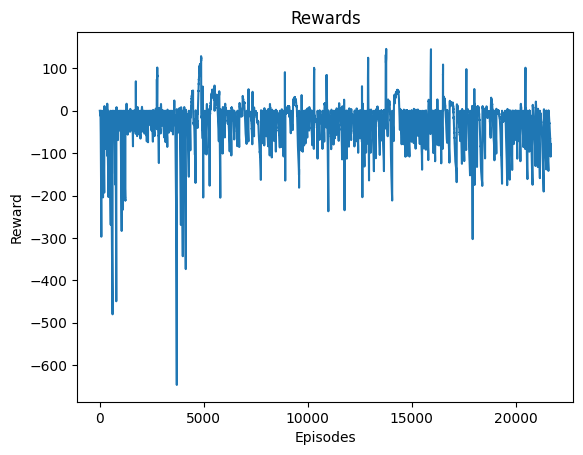

In [10]:
# Iterate over the rows of env.df and append them to df_rewards
for episode, reward in enumerate(agent.rewards()):
    new_row = ["1M", episode, reward]
    df_rewards.loc[len(df_rewards)] = new_row

# Save and plot reward
plt.title("Rewards")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.rewards())
plt.show()

##### Cumulative reward over time/step

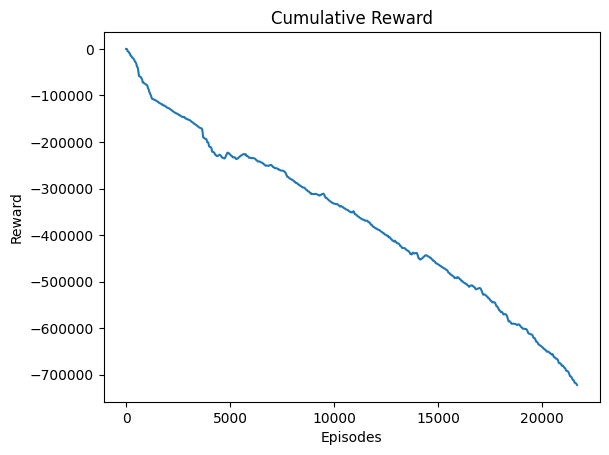

In [11]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.cumulative_reward())
plt.show()

#### WHY does the agent take an actions in the given state?

In [12]:
#we took 10% of experience replay samples as test data. The agent has not seen these yet
len(agent.df)

21580

In [13]:
#data is in tensor format
agent.df.head()

batch_state   
0  [[tensor(-0.2374), tensor(0.8432), tensor(-0.2...  \
1  [[tensor(-0.1499), tensor(1.2927), tensor(-0.4...   
2  [[tensor(-0.2780), tensor(0.2518), tensor(-0.2...   
3  [[tensor(-0.2188), tensor(0.9920), tensor(-0.2...   
4  [[tensor(-0.0718), tensor(1.4142), tensor(-0.5...   

                                    batch_next_state   
0  [[tensor(-0.2403), tensor(0.8161), tensor(-0.2...  \
1  [[tensor(-0.1546), tensor(1.2798), tensor(-0.4...   
2  [[tensor(-0.2798), tensor(0.2120), tensor(-0.2...   
3  [[tensor(-0.2221), tensor(0.9688), tensor(-0.2...   
4  [[tensor(-0.0773), tensor(1.4103), tensor(-0.5...   

                                        batch_action   
0  [tensor(-91.0457), tensor(0.), tensor(-0.1850)...  \
1  [tensor(-7.1419), tensor(-0.8229), tensor(-1.0...   
2  [tensor(-248.2737), tensor(-30.4394), tensor(-...   
3  [tensor(-54.6336), tensor(-259.8345), tensor(-...   
4  [tensor(-6.9879), tensor(-168.1592), tensor(-1...   

                                        batch_reward  
0  [tensor(3), tensor(0), tensor(0), tensor(0), t...  
1  [tensor(3), tensor(0), tensor(0), tensor(3), t...  
2  [tensor(3), tensor(0), tensor(0), tensor(3), t...  
3  [tensor(3), tensor(3), tensor(0), tensor(0), t...  
4  [tensor(0), tensor(3), tensor(0), tensor(3), t...

In [14]:
agent.df.batch_state.values #x coordinate landing pad, y coordinate landing pad, x linear velocity, y linear velocity, angle, angular velocity, left leg contact, right leg contact

array([tensor([[-0.2374,  0.8432, -0.2469, -1.2035, -0.8016, -1.2251,  0.0000,  0.0000],
               [-0.0055,  1.4147, -0.5591,  0.1702,  0.0064,  0.1266,  0.0000,  0.0000],
               [-0.0110,  1.4180, -0.5583,  0.1445,  0.0127,  0.1252,  0.0000,  0.0000],
               [-0.0718,  1.4142, -0.5585, -0.1489,  0.0814,  0.1249,  0.0000,  0.0000],
               [-0.0552,  1.4224, -0.5584, -0.0688,  0.0627,  0.1250,  0.0000,  0.0000],
               [-0.1045,  1.3816, -0.5400, -0.3074,  0.1092,  0.0496,  0.0000,  0.0000],
               [-0.0497,  1.4240, -0.5584, -0.0422,  0.0564,  0.1250,  0.0000,  0.0000],
               [-0.2484,  0.7311, -0.2258, -1.3284, -1.0664, -1.3830,  0.0000,  0.0000],
               [-0.2509,  0.7014, -0.2216, -1.3611, -1.1380, -1.4302,  0.0000,  0.0000],
               [-0.2744,  0.3291, -0.2302, -1.7262, -2.0863, -1.9756,  0.0000,  0.0000]]),
       tensor([[-0.1499,  1.2927, -0.4672, -0.5448,  0.0549, -0.2427,  0.0000,  0.0000],
               [-0.

In [15]:
states = np.concatenate(agent.df.batch_state.values)
states = torch.tensor(states)

In [16]:
# buffer sample for Deep Explainer
print(states)
len(states)

tensor([[-0.2374,  0.8432, -0.2469,  ..., -1.2251,  0.0000,  0.0000],
        [-0.0055,  1.4147, -0.5591,  ...,  0.1266,  0.0000,  0.0000],
        [-0.0110,  1.4180, -0.5583,  ...,  0.1252,  0.0000,  0.0000],
        ...,
        [ 0.0210,  1.0421,  0.0766,  ..., -0.0174,  0.0000,  0.0000],
        [ 0.0507,  0.7185,  0.1271,  ...,  0.0167,  0.0000,  0.0000],
        [ 0.0159,  1.3156,  0.0641,  ...,  0.0402,  0.0000,  0.0000]])


215800

In [17]:
#38401
training_states = states[0:1000] #38398
test_states = states[2000:2100] #38398:38401
print(test_states)
print(len(test_states))

tensor([[ 1.1797e-01,  5.3228e-01,  1.4539e-01, -1.4711e+00,  1.5314e+00,
          9.3778e-01,  0.0000e+00,  0.0000e+00],
        [ 8.3734e-01, -8.6918e-02,  1.9429e+00, -7.8441e-01, -1.0126e+00,
         -2.1286e+00,  0.0000e+00,  0.0000e+00],
        [ 6.4635e-01,  7.3098e-02,  1.8094e+00, -6.4280e-01, -7.1560e-01,
         -2.5825e-01,  0.0000e+00,  0.0000e+00],
        [ 8.5927e-03,  1.3898e+00,  2.1729e-01, -2.7421e-01, -9.7850e-03,
         -4.8674e-02,  0.0000e+00,  0.0000e+00],
        [-1.8534e-01,  1.1730e+00, -3.8571e-01, -7.5986e-01, -1.1442e-01,
         -5.6928e-01,  0.0000e+00,  0.0000e+00],
        [-8.2814e-02,  1.4057e+00, -5.5854e-01, -2.0220e-01,  9.3885e-02,
          1.2486e-01,  0.0000e+00,  0.0000e+00],
        [ 7.4066e-01, -3.1344e-03,  1.9300e+00, -7.3563e-01, -7.8334e-01,
         -3.3403e-01,  0.0000e+00,  0.0000e+00],
        [ 1.3953e-01,  1.1601e+00,  7.0583e-01, -8.1106e-01, -1.5803e-01,
         -1.5764e-01,  0.0000e+00,  0.0000e+00],
        [-9.3451

DeepExplainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples. It's advisable to keep reasonable samples as background because too many samples will give more accurate results but will take a lot of time to compute SHAP values. Generally, 100 random samples are a good choice.

By integrating over many backgound samples [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [18]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, training_states) #training data

In [19]:
# compute shap values
shap_values = explainer.shap_values(test_states) #Returns approximate SHAP values for the model applied to the data given by X. 23.3s for 1000 training in test_states

if explain_row us called it returns a tuple of (row_values, row_expected_values, row_mask_shapes), where:
* row_values is an array of the attribution values for each sample, 
* row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), 
* row_mask_shapes is a list of all the input shapes (since the row_values is always flattened)

In [20]:
shap_values

[array([[-1.07838833e+00,  2.81595516e+00,  7.39968491e+01,
         -5.95362587e+01,  7.55815796e+02,  1.90817535e+02,
         -6.89354229e+00, -4.20389539e-44],
        [-2.26994370e+02,  1.85105019e+01,  2.83676796e+01,
          3.09393048e+00, -1.78782482e+01, -1.01532188e+02,
         -6.89354229e+00, -4.20389539e-44],
        [-1.67012436e+02,  1.44546528e+01,  3.17570381e+01,
          1.60103436e+01,  7.24362640e+01,  7.67881775e+01,
         -6.89354229e+00, -4.20389539e-44],
        [ 3.32706184e+01, -1.89197063e+01,  7.21716843e+01,
          4.96280479e+01,  2.87092102e+02,  9.67688370e+01,
         -6.89354229e+00, -4.20389539e-44],
        [ 9.41740417e+01, -1.34251003e+01,  8.74783401e+01,
          5.33355618e+00,  2.55269897e+02,  4.71347466e+01,
         -6.89354229e+00, -4.20389539e-44],
        [ 6.19765129e+01, -1.93231373e+01,  9.18654404e+01,
          5.61965523e+01,  3.18620758e+02,  1.13313240e+02,
         -6.89354229e+00, -4.20389539e-44],
        [-1.9663

The [summary plot](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16) shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

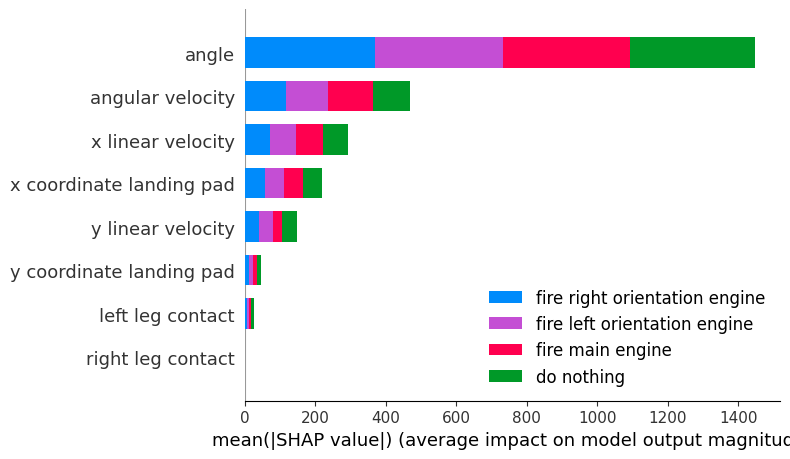

In [21]:

shap.summary_plot(shap_values[:], plot_type = 'bar', feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'], class_names=['do nothing', 'fire left orientation engine', 'fire main engine', 'fire right orientation engine']) #env.df.columns not the best

In [22]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'])

### 500,000 Capacity Size

In [23]:
env = gym.make("LunarLander-v2") #render_mode="human"
observation, info = env.reset(seed=42)
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

4
Discrete(4)
8
[ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]


In [24]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 500000 #memory capacity
m = 100 #memory sampling (100 samples and 10% for shap testing)
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate
agent = Dqn(s,a,g,c,l,t,m)

In [25]:
episodes = 200
for episode in range(episodes):
    observation, info = env.reset()
    done = False
    score = 0
    while not done:
        env.render()       
        action, qValues, transitionProbs = agent.update(score, observation)
        observation, reward, terminated, truncated, info = env.step(int(action))
        score += reward
        done = terminated or truncated
    print("episode: " + str(episode) + ", obs: " + str(observation) + ", action: " + str(int(action)) + ", score: " + str(score))

env.close()

episode: 0, obs: [-4.4486427e-01  3.8775310e-02 -1.3358786e+00 -4.2731458e-01
  4.4736794e-01 -3.8471558e-08  0.0000000e+00  1.0000000e+00], action: 2, score: -138.32947052294088


episode: 1, obs: [ 0.14281902 -0.02575814  0.40469107 -0.27004412  0.21593407 -1.8222964
  0.          1.        ], action: 1, score: -14.296242622522783
episode: 2, obs: [-0.3933137  -0.01123562 -0.7429183  -0.13367352 -4.213042   -0.20461543
  0.          1.        ], action: 1, score: -556.1522187785645
episode: 3, obs: [ 0.473221    0.16882382  0.10598226 -0.22908877 -0.41662025  3.5628552
  1.          0.        ], action: 0, score: -136.75726733217988
episode: 4, obs: [ 0.336376    0.0380313  -0.08287431 -0.4158825  -0.17989609  4.9446487
  0.          0.        ], action: 0, score: -113.57637024084508
episode: 5, obs: [-1.0728464e-01 -4.2802755e-02 -9.2919322e-08  1.8479501e-07
  2.0424626e-04  9.7034626e-07  1.0000000e+00  1.0000000e+00], action: 0, score: -122.13819750211727
episode: 6, obs: [ 0.18954964 -0.03829278  0.180082   -1.0783297  -0.1030729   6.2933507
  1.          1.        ], action: 0, score: -142.9638581995253
episode: 7, obs: [-2.5924125e-01 -6.2000934e-02 -6.9

#### HOW did the agent performed?

##### Agent's final score

In [26]:
#Current sum of all values in the reward window
print(agent.score())

-984280.5681815469


##### Rewards at given time/step

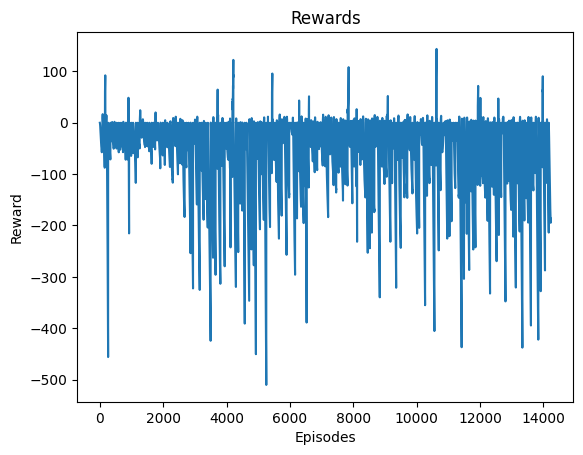

In [27]:
# Iterate over the rows of env.df and append them to df_rewards
for episode, reward in enumerate(agent.rewards()):
    new_row = ["500k", episode, reward]
    df_rewards.loc[len(df_rewards)] = new_row

# Save and plot reward
plt.title("Rewards")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.rewards())
plt.show()

##### Cumulative reward over time/step

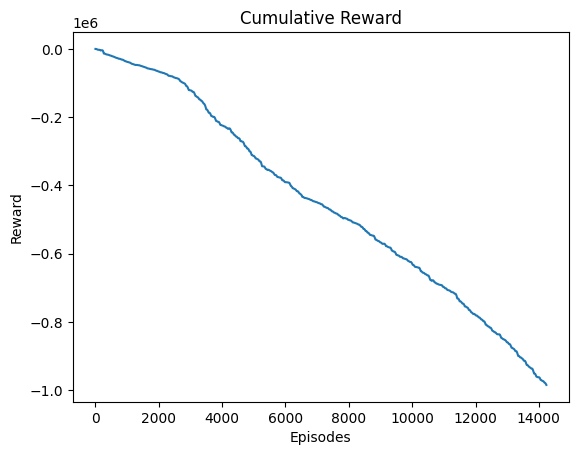

In [28]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.cumulative_reward())
plt.show()

#### WHY does the agent take an actions in the given state?

In [29]:
#we took 10% of experience replay samples as test data. The agent has not seen these yet
len(agent.df)

14138

In [30]:
#data is in tensor format
agent.df.head()

batch_state   
0  [[tensor(-0.2319), tensor(1.0561), tensor(-0.5...  \
1  [[tensor(-0.0773), tensor(1.4103), tensor(-0.5...   
2  [[tensor(-0.3259), tensor(0.6117), tensor(-0.5...   
3  [[tensor(-0.3967), tensor(0.2168), tensor(-0.6...   
4  [[tensor(0.0048), tensor(1.4346), tensor(0.160...   

                                    batch_next_state   
0  [[tensor(-0.2375), tensor(1.0348), tensor(-0.5...  \
1  [[tensor(-0.0828), tensor(1.4057), tensor(-0.5...   
2  [[tensor(-0.3314), tensor(0.5801), tensor(-0.5...   
3  [[tensor(-0.4035), tensor(0.1848), tensor(-0.6...   
4  [[tensor(0.0063), tensor(1.4412), tensor(0.160...   

                                        batch_action   
0  [tensor(-41.7001), tensor(15.7865), tensor(-13...  \
1  [tensor(-7.9930), tensor(-20.1449), tensor(-36...   
2  [tensor(-54.1277), tensor(15.4317), tensor(-21...   
3  [tensor(-50.7501), tensor(-38.6556), tensor(-1...   
4  [tensor(2.8858), tensor(-43.5717), tensor(7.46...   

                                        batch_reward  
0  [tensor(0), tensor(0), tensor(0), tensor(0), t...  
1  [tensor(0), tensor(0), tensor(0), tensor(0), t...  
2  [tensor(0), tensor(0), tensor(0), tensor(2), t...  
3  [tensor(2), tensor(0), tensor(0), tensor(0), t...  
4  [tensor(0), tensor(0), tensor(0), tensor(0), t...

In [31]:
agent.df.batch_state.values #x coordinate landing pad, y coordinate landing pad, x linear velocity, y linear velocity, angle, angular velocity, left leg contact, right leg contact

array([tensor([[-0.2319,  1.0561, -0.5585, -0.9233,  0.2622,  0.1246,  0.0000,  0.0000],
               [ 0.0270,  1.4736,  0.1606, -0.0495, -0.0306, -0.0359,  0.0000,  0.0000],
               [-0.1049,  1.3816, -0.5586, -0.3089,  0.1188,  0.1248,  0.0000,  0.0000],
               [ 0.0238,  1.4752,  0.1606,  0.0038, -0.0270, -0.0359,  0.0000,  0.0000],
               [-0.2099,  1.1355, -0.5585, -0.8166,  0.2373,  0.1246,  0.0000,  0.0000],
               [-0.1546,  1.2921, -0.5585, -0.5499,  0.1750,  0.1246,  0.0000,  0.0000],
               [-0.2761,  0.8686, -0.5585, -1.1366,  0.3121,  0.1246,  0.0000,  0.0000],
               [-0.0110,  1.4180, -0.5583,  0.1445,  0.0127,  0.1252,  0.0000,  0.0000],
               [-0.1822,  1.2213, -0.5585, -0.6832,  0.2061,  0.1246,  0.0000,  0.0000],
               [ 0.0333,  1.4631,  0.1606, -0.1562, -0.0377, -0.0359,  0.0000,  0.0000]]),
       tensor([[-0.0773,  1.4103, -0.5585, -0.1755,  0.0876,  0.1249,  0.0000,  0.0000],
               [-0.

In [32]:
states = np.concatenate(agent.df.batch_state.values)
states = torch.tensor(states)

In [33]:
# buffer sample for Deep Explainer
print(states)
len(states)

tensor([[-0.2319,  1.0561, -0.5585,  ...,  0.1246,  0.0000,  0.0000],
        [ 0.0270,  1.4736,  0.1606,  ..., -0.0359,  0.0000,  0.0000],
        [-0.1049,  1.3816, -0.5586,  ...,  0.1248,  0.0000,  0.0000],
        ...,
        [-0.0632,  1.3525, -0.3453,  ..., -0.4428,  0.0000,  0.0000],
        [-0.1039,  0.7753, -0.2542,  ..., -0.3082,  0.0000,  0.0000],
        [ 0.1182,  1.2302,  0.5248,  ...,  0.5408,  0.0000,  0.0000]])


141380

In [34]:
#38401
training_states = states[0:1000] #38398
test_states = states[2000:2100] #38398:38401
print(test_states)
print(len(test_states))

tensor([[ 0.0540,  1.3626,  0.1606, -0.5038, -0.0610, -0.0358,  0.0000,  0.0000],
        [-0.0110,  1.4180, -0.5583,  0.1445,  0.0127,  0.1252,  0.0000,  0.0000],
        [ 0.1224,  1.3989,  0.6517, -0.2684, -0.1386, -0.1456,  0.0000,  0.0000],
        [-0.1378,  1.5255, -0.6055, -0.0469,  0.1439,  0.0189,  0.0000,  0.0000],
        [-0.3314,  0.5801, -0.5585, -1.4033,  0.3744,  0.1246,  0.0000,  0.0000],
        [ 0.0286,  1.4719,  0.1606, -0.0762, -0.0324, -0.0359,  0.0000,  0.0000],
        [ 0.2126,  1.2515,  0.6516, -0.6428, -0.2408, -0.1454,  0.0000,  0.0000],
        [ 0.0825,  0.7454, -0.0497, -1.3105,  0.3657,  0.8190,  0.0000,  0.0000],
        [-0.0607,  1.4203, -0.5585, -0.0955,  0.0689,  0.1249,  0.0000,  0.0000],
        [-0.3770,  0.3142, -0.6209, -1.4881,  0.4279,  0.1433,  0.0000,  0.0000],
        [ 0.0193,  1.4234,  0.6514,  0.1584, -0.0221, -0.1459,  0.0000,  0.0000],
        [-0.2872,  0.8157, -0.5585, -1.1900,  0.3245,  0.1246,  0.0000,  0.0000],
        [ 0.0902

DeepExplainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples. It's advisable to keep reasonable samples as background because too many samples will give more accurate results but will take a lot of time to compute SHAP values. Generally, 100 random samples are a good choice.

By integrating over many backgound samples [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [35]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, training_states) #training data

In [36]:
# compute shap values
shap_values = explainer.shap_values(test_states) #Returns approximate SHAP values for the model applied to the data given by X. 23.3s for 1000 training in test_states

if explain_row us called it returns a tuple of (row_values, row_expected_values, row_mask_shapes), where:
* row_values is an array of the attribution values for each sample, 
* row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), 
* row_mask_shapes is a list of all the input shapes (since the row_values is always flattened)

In [37]:
shap_values

[array([[ 4.89638186e+00, -2.50596333e+01, -2.82246923e+00,
          1.58005028e+01, -2.17830334e+01, -1.12497301e+01,
          6.61685459e+24, -4.92457448e+19],
        [ 2.70571113e+00, -2.98626251e+01,  1.99814677e+00,
          9.29300461e+01, -1.48168602e+01,  1.24909246e+00,
          6.61685459e+24, -4.92457448e+19],
        [ 7.20199251e+00, -2.82067242e+01, -6.11608934e+00,
          4.38060150e+01, -2.91176376e+01, -1.97687531e+01,
          6.61685459e+24, -4.92457448e+19],
        [-1.56563437e+00, -3.91913986e+01,  2.31488276e+00,
          7.01581650e+01, -2.41534352e+00, -6.99713516e+00,
          6.61685459e+24, -4.92457448e+19],
        [-8.08930492e+00,  4.28386383e+01,  1.99918509e+00,
         -9.12059326e+01,  1.93740845e+01,  1.20836580e+00,
          6.61685459e+24, -4.92457448e+19],
        [ 4.04040956e+00, -3.45355492e+01, -2.82264185e+00,
          6.66745224e+01, -1.90725613e+01, -1.12529011e+01,
          6.61685459e+24, -4.92457448e+19],
        [ 1.0242

The [summary plot](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16) shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

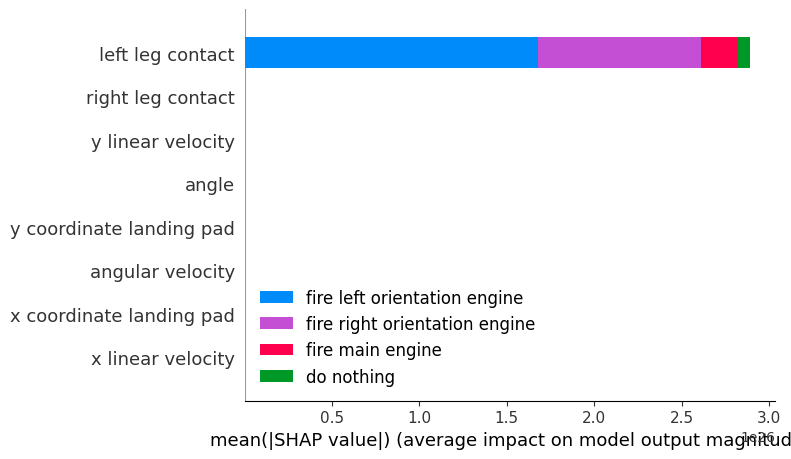

In [38]:

shap.summary_plot(shap_values[:], plot_type = 'bar', feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'], class_names=['do nothing', 'fire left orientation engine', 'fire main engine', 'fire right orientation engine']) #env.df.columns not the best

In [39]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'])

### 100,000 Capacity Size

In [40]:
env = gym.make("LunarLander-v2") #render_mode="human"
observation, info = env.reset(seed=42)
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

4
Discrete(4)
8
[ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]


In [41]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 100000 #memory capacity
m = 100 #memory sampling (100 samples and 10% for shap testing)
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate
agent = Dqn(s,a,g,c,l,t,m)

In [42]:
episodes = 200
for episode in range(episodes):
    observation, info = env.reset()
    done = False
    score = 0
    while not done:
        env.render()       
        action, qValues, transitionProbs = agent.update(score, observation)
        observation, reward, terminated, truncated, info = env.step(int(action))
        score += reward
        done = terminated or truncated
    print("episode: " + str(episode) + ", obs: " + str(observation) + ", action: " + str(int(action)) + ", score: " + str(score))

env.close()

episode: 0, obs: [-0.6443171  -0.05069685 -0.6220715  -0.24241105  0.25293526 -2.1240199
  1.          0.        ], action: 1, score: -64.02298938194119
episode: 1, obs: [ 0.2982773   0.05145715  0.02647327 -0.00634521  2.4211984  -0.28954855
  0.          0.        ], action: 0, score: -343.27777134535665


episode: 2, obs: [ 5.3074647e-02 -2.4333620e-03  1.6737190e-01 -1.8784164e-01
  6.2580544e-01 -3.2209816e+00  0.0000000e+00  1.0000000e+00], action: 0, score: -185.14145585658898
episode: 3, obs: [ 0.15366116  0.0173539  -0.16181624  0.02903176  3.8294077   1.1405914
  0.          0.        ], action: 0, score: -349.15814484007626
episode: 4, obs: [-0.42564696  0.06171671 -0.84650314 -0.9194917   0.20018053 -5.8780484
  0.          1.        ], action: 1, score: -137.0205932365596
episode: 5, obs: [-0.5355802   0.02348014 -0.79833114 -0.8283013   0.5206028  -5.488934
  0.          1.        ], action: 1, score: -179.25788992504178
episode: 6, obs: [-0.51223624 -0.11022955 -0.689813   -0.5584824   0.38186732 -5.4840107
  0.          1.        ], action: 1, score: -165.0386456540524
episode: 7, obs: [-0.14844903 -0.0171015  -0.0965912  -0.6554316   0.34006307 -5.7166104
  0.          1.        ], action: 2, score: -155.1417914473338
episode: 8, obs: [ 0.10924139 -0.00793826  0.29306683 -

#### HOW did the agent performed?

##### Agent's final score

In [43]:
#Current sum of all values in the reward window
print(agent.score())

-887472.3128197191


##### Rewards at given time/step

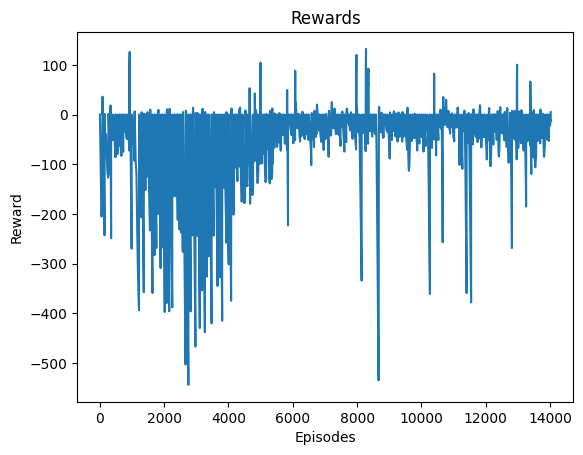

In [44]:
# Iterate over the rows of env.df and append them to df_rewards
for episode, reward in enumerate(agent.rewards()):
    new_row = ["100k", episode, reward]
    df_rewards.loc[len(df_rewards)] = new_row


# Save and plot reward
plt.title("Rewards")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.rewards())
plt.show()

##### Cumulative reward over time/step

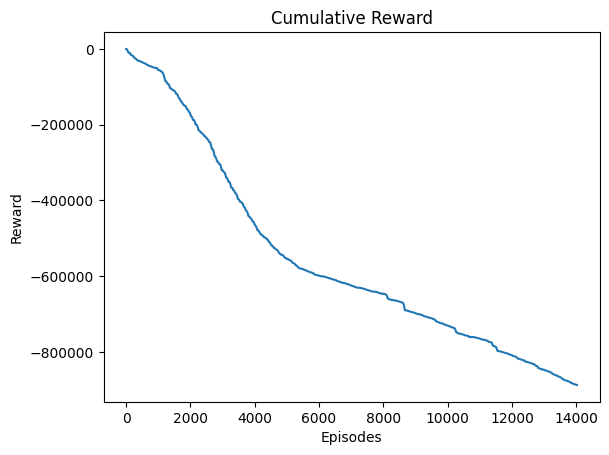

In [45]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.cumulative_reward())
plt.show()

#### WHY does the agent take an actions in the given state?

In [46]:
#we took 10% of experience replay samples as test data. The agent has not seen these yet
len(agent.df)

13924

In [47]:
#data is in tensor format
agent.df.head()

batch_state   
0  [[tensor(-0.0781), tensor(1.4138), tensor(-0.6...  \
1  [[tensor(-0.4937), tensor(0.3619), tensor(-0.7...   
2  [[tensor(-0.2303), tensor(1.1993), tensor(-0.7...   
3  [[tensor(0.0269), tensor(1.3951), tensor(0.665...   
4  [[tensor(-0.5828), tensor(0.0137), tensor(-0.6...   

                                    batch_next_state   
0  [[tensor(-0.0846), tensor(1.4097), tensor(-0.6...  \
1  [[tensor(-0.5017), tensor(0.3287), tensor(-0.7...   
2  [[tensor(-0.2378), tensor(1.1829), tensor(-0.7...   
3  [[tensor(0.0335), tensor(1.3896), tensor(0.653...   
4  [[tensor(-0.5893), tensor(0.0079), tensor(-0.6...   

                                        batch_action   
0  [tensor(-35.0463), tensor(4.5656), tensor(-5.3...  \
1  [tensor(-183.9454), tensor(-1.4360), tensor(-4...   
2  [tensor(-156.3072), tensor(-178.6118), tensor(...   
3  [tensor(0.3100), tensor(-202.6811), tensor(-18...   
4  [tensor(-35.2847), tensor(-14.8842), tensor(-1...   

                                        batch_reward  
0  [tensor(1), tensor(1), tensor(1), tensor(1), t...  
1  [tensor(3), tensor(1), tensor(1), tensor(1), t...  
2  [tensor(3), tensor(3), tensor(3), tensor(1), t...  
3  [tensor(1), tensor(3), tensor(1), tensor(1), t...  
4  [tensor(1), tensor(1), tensor(3), tensor(1), t...

In [48]:
agent.df.batch_state.values #x coordinate landing pad, y coordinate landing pad, x linear velocity, y linear velocity, angle, angular velocity, left leg contact, right leg contact

array([tensor([[-0.0781,  1.4138, -0.6790, -0.1564,  0.2397,  0.6100,  0.0000,  0.0000],
               [ 0.0650,  1.3534,  0.6054, -0.3754,  0.0050,  0.1865,  0.0000,  0.0000],
               [-0.0226,  1.4227, -0.5902,  0.0902,  0.0381,  0.2529,  0.0000,  0.0000],
               [-0.0716,  1.4172, -0.6706, -0.1287,  0.2092,  0.5757,  0.0000,  0.0000],
               [-0.3447,  0.8998, -0.7666, -1.0494,  1.7548,  0.2997,  0.0000,  0.0000],
               [-0.0403,  1.4252, -0.6183,  0.0090,  0.0869,  0.3653,  0.0000,  0.0000],
               [-0.5337,  0.1912, -0.7915, -1.5302,  1.3706, -0.9114,  0.0000,  0.0000],
               [-0.6092, -0.0112, -0.6005, -0.2588,  0.7088, -1.8913,  0.0000,  1.0000],
               [-0.4146,  0.6672, -0.7854, -1.2332,  1.7795, -0.1306,  0.0000,  0.0000],
               [-0.1849,  1.2870, -0.7946, -0.6021,  0.9484,  1.1814,  0.0000,  0.0000]]),
       tensor([[-0.4937,  0.3619, -0.7971, -1.4324,  1.5735, -0.6418,  0.0000,  0.0000],
               [-0.

In [49]:
states = np.concatenate(agent.df.batch_state.values)
states = torch.tensor(states)

In [50]:
# buffer sample for Deep Explainer
print(states)
len(states)

tensor([[-0.0781,  1.4138, -0.6790,  ...,  0.6100,  0.0000,  0.0000],
        [ 0.0650,  1.3534,  0.6054,  ...,  0.1865,  0.0000,  0.0000],
        [-0.0226,  1.4227, -0.5902,  ...,  0.2529,  0.0000,  0.0000],
        ...,
        [-0.0072,  1.3712, -0.2422,  ...,  0.0543,  0.0000,  0.0000],
        [ 0.1547,  0.1828, -0.4687,  ..., -0.2453,  0.0000,  0.0000],
        [-0.0646,  1.4364, -0.5941,  ...,  0.1329,  0.0000,  0.0000]])


139240

In [51]:
#38401
training_states = states[0:1000] #38398
test_states = states[2000:2100] #38398:38401
print(test_states)
print(len(test_states))

tensor([[ 5.3418e-02,  6.1033e-02, -9.8550e-02, -1.8371e+00,  6.8461e-01,
          3.0468e-01,  0.0000e+00,  1.0000e+00],
        [ 4.7791e-02,  8.7485e-01,  3.5590e-02, -1.3515e+00,  3.9355e-01,
          2.2269e-01,  0.0000e+00,  0.0000e+00],
        [-9.5615e-04,  1.4202e+00, -7.0381e-03,  1.0176e-01, -8.8309e-04,
          8.2876e-03,  0.0000e+00,  0.0000e+00],
        [-1.6223e-01,  1.3239e+00, -7.8606e-01, -5.1431e-01,  7.7016e-01,
          1.1190e+00,  0.0000e+00,  0.0000e+00],
        [ 4.8710e-02,  8.1237e-01,  3.5602e-02, -1.4048e+00,  4.1582e-01,
          2.2268e-01,  0.0000e+00,  0.0000e+00],
        [-2.7579e-01,  1.0926e+00, -7.6282e-01, -8.6986e-01,  1.5304e+00,
          7.5677e-01,  0.0000e+00,  0.0000e+00],
        [ 2.6347e-01,  4.1467e-01,  3.8823e-01, -1.5589e+00,  1.9138e+00,
          1.0699e+00,  0.0000e+00,  0.0000e+00],
        [ 7.3620e-03,  1.4063e+00,  3.6787e-01, -1.1624e-01, -7.0016e-03,
         -5.4176e-02,  0.0000e+00,  0.0000e+00],
        [-4.3032

DeepExplainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples. It's advisable to keep reasonable samples as background because too many samples will give more accurate results but will take a lot of time to compute SHAP values. Generally, 100 random samples are a good choice.

By integrating over many backgound samples [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [52]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, training_states) #training data

In [53]:
# compute shap values
shap_values = explainer.shap_values(test_states) #Returns approximate SHAP values for the model applied to the data given by X. 23.3s for 1000 training in test_states

if explain_row us called it returns a tuple of (row_values, row_expected_values, row_mask_shapes), where:
* row_values is an array of the attribution values for each sample, 
* row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), 
* row_mask_shapes is a list of all the input shapes (since the row_values is always flattened)

In [54]:
shap_values

[array([[ 2.28504944e+01,  4.28883209e+01, -2.50717030e+01,
         -1.81386185e+02,  1.35716232e+02,  3.12395267e+01,
          7.51920244e+24, -6.35848839e+18],
        [ 2.18574772e+01,  6.81331539e+00, -3.02889118e+01,
         -1.02250946e+02,  3.26715881e+02,  5.59680557e+01,
          7.51920244e+24, -6.35848839e+18],
        [ 1.32566242e+01, -1.73607464e+01, -2.86309013e+01,
          1.34573029e+02,  5.85553894e+02,  1.20632492e+02,
          7.51920244e+24, -6.35848839e+18],
        [-1.51987419e+01, -1.30908804e+01,  1.66755772e+00,
          3.41769562e+01,  7.95776901e+01, -2.14368713e+02,
          7.51920244e+24, -6.35848839e+18],
        [ 2.20196781e+01,  9.58310318e+00, -3.02893181e+01,
         -1.10945343e+02,  3.12102600e+02,  5.59693031e+01,
          7.51920244e+24, -6.35848839e+18],
        [-3.52357864e+01, -2.84069967e+00,  7.64029741e-01,
         -2.37648373e+01, -4.19337677e+02, -1.05114861e+02,
          7.51920244e+24, -6.35848839e+18],
        [ 5.9912

The [summary plot](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16) shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

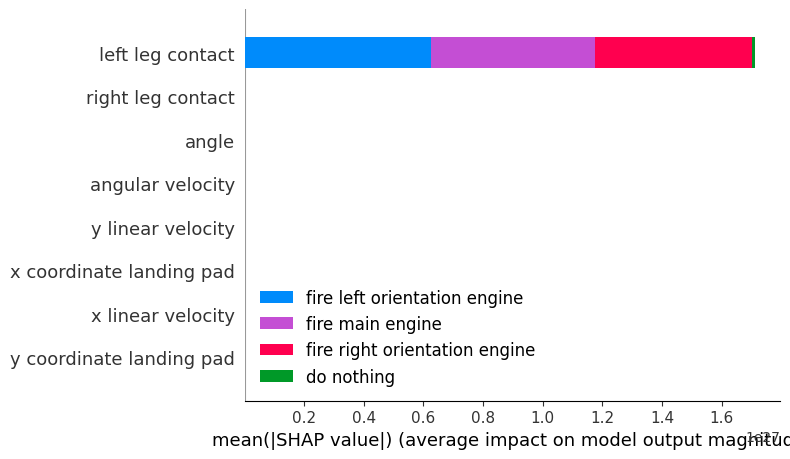

In [55]:

shap.summary_plot(shap_values[:], plot_type = 'bar', feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'], class_names=['do nothing', 'fire left orientation engine', 'fire main engine', 'fire right orientation engine']) #env.df.columns not the best

In [56]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'])

### 50,000 Capacity Size

In [57]:
env = gym.make("LunarLander-v2") #render_mode="human"
observation, info = env.reset(seed=42)
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

4
Discrete(4)
8
[ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]


In [58]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 50000 #memory capacity
m = 100 #memory sampling (100 samples and 10% for shap testing)
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate
agent = Dqn(s,a,g,c,l,t,m)

In [59]:
episodes = 200
for episode in range(episodes):
    observation, info = env.reset()
    done = False
    score = 0
    while not done:
        env.render()       
        action, qValues, transitionProbs = agent.update(score, observation)
        observation, reward, terminated, truncated, info = env.step(int(action))
        score += reward
        done = terminated or truncated
    print("episode: " + str(episode) + ", obs: " + str(observation) + ", action: " + str(int(action)) + ", score: " + str(score))

env.close()

episode: 0, obs: [-1.0147682   3.4321628  -2.049575    1.64551     0.5417931   0.14923672
  0.          0.        ], action: 2, score: -591.3480319651924


episode: 1, obs: [ 1.004442    1.6437993   1.6402292  -0.4992088  -1.3642069   0.06538714
  0.          0.        ], action: 1, score: -396.158994578267
episode: 2, obs: [-0.6813948  -0.07941133 -1.1022217  -1.3745326   6.476963    6.8021913
  1.          0.        ], action: 0, score: -766.3591703608655
episode: 3, obs: [-6.0341168e-02 -4.2797066e-02 -9.8122425e-02 -2.5189324e-08
  2.5728787e-04  2.4498149e-07  1.0000000e+00  1.0000000e+00], action: 0, score: 8.53492934513433
episode: 4, obs: [ 1.1640549e-02 -4.2738415e-02  1.3640509e-07 -2.3959716e-08
 -9.1444724e-04 -6.1703963e-07  1.0000000e+00  1.0000000e+00], action: 0, score: -46.05095616371517
episode: 5, obs: [ 2.8902808e-01 -3.3991360e-03  4.4127083e-01 -4.7541341e-01
 -9.1358930e-02  4.1349158e+00  1.0000000e+00  0.0000000e+00], action: 0, score: -96.3642072591557
episode: 6, obs: [-0.4876383  -0.07270713 -0.820936   -1.157789    0.41969588 -5.4292235
  1.          1.        ], action: 0, score: -178.48584295024747
episode: 

#### HOW did the agent performed?

##### Agent's final score

In [60]:
#Current sum of all values in the reward window
print(agent.score())

-861243.4603643608


##### Rewards at given time/step

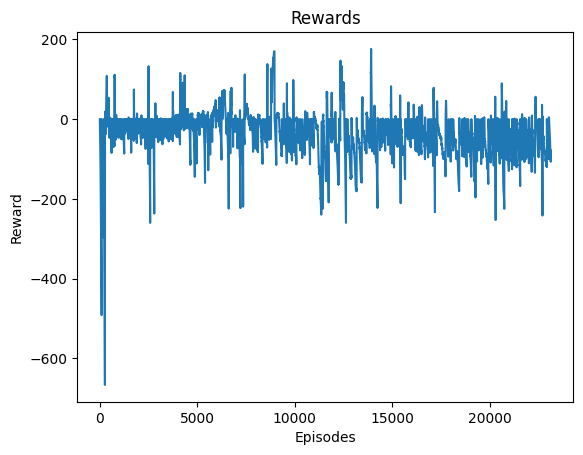

In [61]:
# Iterate over the rows of env.df and append them to df_rewards
for episode, reward in enumerate(agent.rewards()):
    new_row = ["50k", episode, reward]
    df_rewards.loc[len(df_rewards)] = new_row
# Save and plot reward
plt.title("Rewards")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.rewards())
plt.show()

##### Cumulative reward over time/step

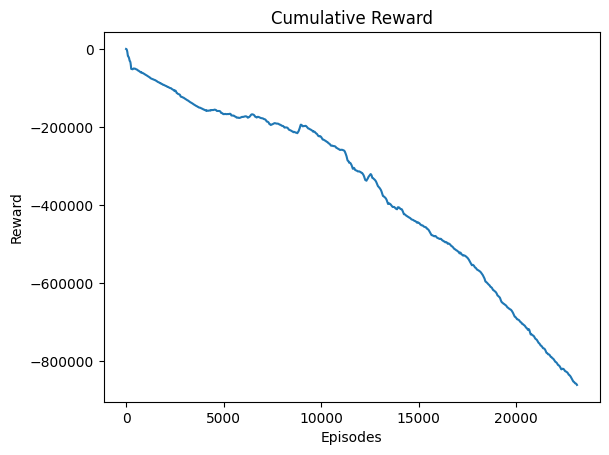

In [62]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.cumulative_reward())
plt.show()

#### WHY does the agent take an actions in the given state?

In [63]:
#we took 10% of experience replay samples as test data. The agent has not seen these yet
len(agent.df)

23025

In [64]:
#data is in tensor format
agent.df.head()

batch_state   
0  [[tensor(-0.8979), tensor(3.2149), tensor(-1.8...  \
1  [[tensor(-0.0933), tensor(1.5192), tensor(-0.6...   
2  [[tensor(-0.3610), tensor(2.0764), tensor(-0.9...   
3  [[tensor(-0.0565), tensor(1.4648), tensor(-0.5...   
4  [[tensor(-0.0747), tensor(1.4900), tensor(-0.6...   

                                    batch_next_state   
0  [[tensor(-0.9166), tensor(3.2503), tensor(-1.8...  \
1  [[tensor(-0.0996), tensor(1.5299), tensor(-0.6...   
2  [[tensor(-0.3704), tensor(2.0977), tensor(-0.9...   
3  [[tensor(-0.0626), tensor(1.4725), tensor(-0.6...   
4  [[tensor(-0.0807), tensor(1.4995), tensor(-0.6...   

                                        batch_action   
0  [tensor(-452.1732), tensor(-105.0991), tensor(...  \
1  [tensor(-43.1619), tensor(-32.7318), tensor(-5...   
2  [tensor(-183.7429), tensor(-200.8231), tensor(...   
3  [tensor(-22.7641), tensor(-95.0880), tensor(-3...   
4  [tensor(-32.7318), tensor(-421.9190), tensor(-...   

                                        batch_reward  
0  [tensor(2), tensor(2), tensor(2), tensor(2), t...  
1  [tensor(2), tensor(2), tensor(2), tensor(2), t...  
2  [tensor(2), tensor(2), tensor(2), tensor(2), t...  
3  [tensor(2), tensor(2), tensor(2), tensor(2), t...  
4  [tensor(2), tensor(2), tensor(2), tensor(2), t...

In [65]:
agent.df.batch_state.values #x coordinate landing pad, y coordinate landing pad, x linear velocity, y linear velocity, angle, angular velocity, left leg contact, right leg contact

array([tensor([[-0.8979,  3.2149, -1.8544,  1.5694,  0.4960,  0.1442,  0.0000,  0.0000],
               [-0.2064,  1.7335, -0.7931,  0.7036,  0.1576,  0.0670,  0.0000,  0.0000],
               [-0.0933,  1.5192, -0.6360,  0.4520,  0.0898,  0.0966,  0.0000,  0.0000],
               [-0.3063,  1.9505, -0.8764,  0.8935,  0.2135,  0.1208,  0.0000,  0.0000],
               [-0.6087,  2.6200, -1.3670,  1.3040,  0.3621,  0.1306,  0.0000,  0.0000],
               [-0.6363,  2.6792, -1.4030,  1.3122,  0.3758,  0.1300,  0.0000,  0.0000],
               [-0.3330,  2.0131, -0.9093,  0.9328,  0.2326,  0.1273,  0.0000,  0.0000],
               [-0.1394,  1.6019, -0.7005,  0.5612,  0.1235,  0.0790,  0.0000,  0.0000],
               [ 0.0224,  1.4169,  0.7505,  0.0936, -0.0252, -0.1724,  0.0000,  0.0000],
               [-0.4924,  2.3678, -1.2246,  1.1850,  0.3110,  0.0902,  0.0000,  0.0000]]),
       tensor([[-0.0933,  1.5192, -0.6360,  0.4520,  0.0898,  0.0966,  0.0000,  0.0000],
               [-0.

In [66]:
states = np.concatenate(agent.df.batch_state.values)
states = torch.tensor(states)

In [67]:
# buffer sample for Deep Explainer
print(states)
len(states)

tensor([[-0.8979,  3.2149, -1.8544,  ...,  0.1442,  0.0000,  0.0000],
        [-0.2064,  1.7335, -0.7931,  ...,  0.0670,  0.0000,  0.0000],
        [-0.0933,  1.5192, -0.6360,  ...,  0.0966,  0.0000,  0.0000],
        ...,
        [ 0.0275,  1.4358,  0.2133,  ...,  0.0181,  0.0000,  0.0000],
        [ 0.0102,  1.4763,  0.0795,  ..., -0.0178,  0.0000,  0.0000],
        [ 0.2839,  0.0436, -0.2579,  ..., -0.9008,  0.0000,  1.0000]])


230250

In [68]:
#38401
training_states = states[0:1000] #38398
test_states = states[2000:2100] #38398:38401
print(test_states)
print(len(test_states))

tensor([[-1.4363e-03,  1.4303e+00, -3.6329e-02,  1.7550e-01,  1.6437e-03,
          8.1383e-03,  0.0000e+00,  0.0000e+00],
        [ 6.8740e-02,  1.4403e+00,  8.0148e-01,  2.2583e-01, -7.0962e-02,
         -1.4068e-01,  0.0000e+00,  0.0000e+00],
        [ 4.7251e-01,  1.8030e+00,  9.8274e-01,  2.9471e-02, -5.5692e-01,
         -2.8811e-01,  0.0000e+00,  0.0000e+00],
        [ 3.1852e-01,  1.7176e+00,  9.7268e-01,  4.6085e-01, -3.6589e-01,
         -2.3552e-01,  0.0000e+00,  0.0000e+00],
        [-1.2178e-01,  1.4455e+00, -8.5567e-01, -1.1565e-01,  3.4557e-01,
          7.3124e-01,  0.0000e+00,  0.0000e+00],
        [-1.7955e-03,  1.4336e+00, -3.6330e-02,  1.4883e-01,  2.0506e-03,
          8.1370e-03,  0.0000e+00,  0.0000e+00],
        [ 1.3319e-01,  1.4931e+00,  8.1558e-01,  3.5057e-01, -1.3230e-01,
         -1.7540e-01,  0.0000e+00,  0.0000e+00],
        [-5.1037e-01,  7.6087e-01, -8.3775e-01, -1.3592e+00,  3.7657e+00,
          2.4766e+00,  0.0000e+00,  0.0000e+00],
        [-1.6777

DeepExplainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples. It's advisable to keep reasonable samples as background because too many samples will give more accurate results but will take a lot of time to compute SHAP values. Generally, 100 random samples are a good choice.

By integrating over many backgound samples [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [69]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, training_states) #training data

In [70]:
# compute shap values
shap_values = explainer.shap_values(test_states) #Returns approximate SHAP values for the model applied to the data given by X. 23.3s for 1000 training in test_states

if explain_row us called it returns a tuple of (row_values, row_expected_values, row_mask_shapes), where:
* row_values is an array of the attribution values for each sample, 
* row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), 
* row_mask_shapes is a list of all the input shapes (since the row_values is always flattened)

In [71]:
shap_values

[array([[-4.75241295e+20,  4.74838524e+01, -2.58743782e+01,
         -1.11237755e+02,  5.00841141e-01,  4.74128976e+20,
         -3.91504784e-09, -3.26571192e-09],
        [-4.75241295e+20,  4.65973396e+01, -8.20192184e+01,
         -1.00618256e+02,  1.14072084e+00,  4.74128976e+20,
         -3.91504784e-09, -3.26571192e-09],
        [-4.75241295e+20,  1.43297768e+01, -9.41663513e+01,
         -1.42054214e+02,  5.42355061e+00,  4.74128976e+20,
         -3.91504784e-09, -3.26571192e-09],
        [-4.75241295e+20,  2.19309158e+01, -9.34926834e+01,
         -5.10223694e+01,  3.73997402e+00,  4.74128976e+20,
         -3.91504784e-09, -3.26571192e-09],
        [-4.75241295e+20,  4.61292229e+01,  2.90331593e+01,
         -1.72677765e+02, -2.53022170e+00,  4.74128976e+20,
         -3.91504784e-09, -3.26571192e-09],
        [-4.75241295e+20,  4.71859245e+01, -2.58743362e+01,
         -1.16865501e+02,  4.97256309e-01,  4.74128976e+20,
         -3.91504784e-09, -3.26571192e-09],
        [-4.7524

The [summary plot](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16) shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

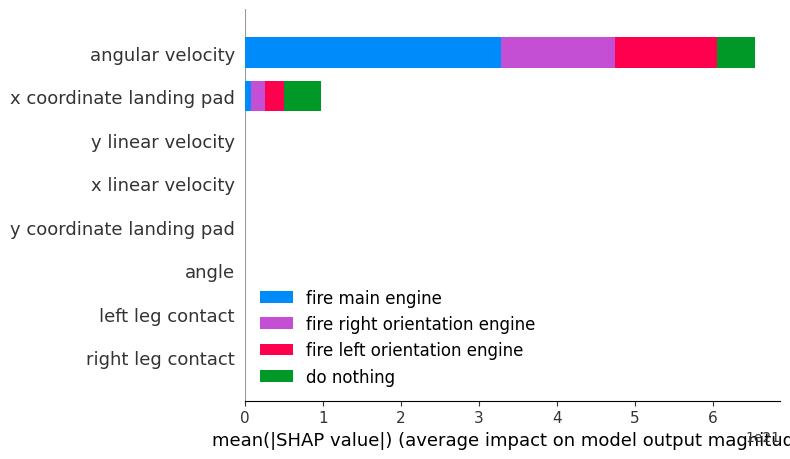

In [72]:

shap.summary_plot(shap_values[:], plot_type = 'bar', feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'], class_names=['do nothing', 'fire left orientation engine', 'fire main engine', 'fire right orientation engine']) #env.df.columns not the best

In [73]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'])

### 10,000 Capacity Size

In [74]:
env = gym.make("LunarLander-v2") #render_mode="human"
observation, info = env.reset(seed=42)
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

4
Discrete(4)
8
[ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]


In [75]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 10000 #memory capacity
m = 100 #memory sampling (100 samples and 10% for shap testing)
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate
agent = Dqn(s,a,g,c,l,t,m)

In [76]:
episodes = 200
for episode in range(episodes):
    observation, info = env.reset()
    done = False
    score = 0
    while not done:
        env.render()       
        action, qValues, transitionProbs = agent.update(score, observation)
        observation, reward, terminated, truncated, info = env.step(int(action))
        score += reward
        done = terminated or truncated
    print("episode: " + str(episode) + ", obs: " + str(observation) + ", action: " + str(int(action)) + ", score: " + str(score))

env.close()

episode: 0, obs: [-1.0044205  0.6583381 -0.9626026 -1.6985513  8.281312   3.1714358
  0.         0.       ], action: 3, score: -1038.2854382009023


episode: 1, obs: [ 1.0010376   0.5567633   2.1220284  -0.9446489  -1.1237044   0.30305228
  0.          0.        ], action: 1, score: -357.11878934396947
episode: 2, obs: [ 0.2876629   0.07532988  0.3189922  -0.28759876 -1.0185319  -5.08266
  1.          0.        ], action: 2, score: -103.38188695746392
episode: 3, obs: [-1.0038503   2.6241107  -1.3196365  -0.41310465  2.2491865   0.9192076
  0.          0.        ], action: 1, score: -584.2667294503758
episode: 4, obs: [-0.3373956  -0.04740034 -1.291507   -0.41142532  2.806484    4.29575
  0.          0.        ], action: 1, score: -418.44472351373156
episode: 5, obs: [-0.5513305   0.07965518 -0.23737419 -0.5226624   4.0700645   6.9148345
  1.          0.        ], action: 3, score: -524.8368610508344
episode: 6, obs: [-9.0757108e-01 -4.4512987e-04 -9.2208803e-01 -7.7715135e-01
  2.5601850e+00 -7.8210921e+00  0.0000000e+00  0.0000000e+00], action: 3, score: -582.6538307577989
episode: 7, obs: [ 0.1703765  -0.02783399 -0.5051919  -0.

#### HOW did the agent performed?

##### Agent's final score

In [77]:
#Current sum of all values in the reward window
print(agent.score())

-2008883.0171249427


##### Rewards at given time/step

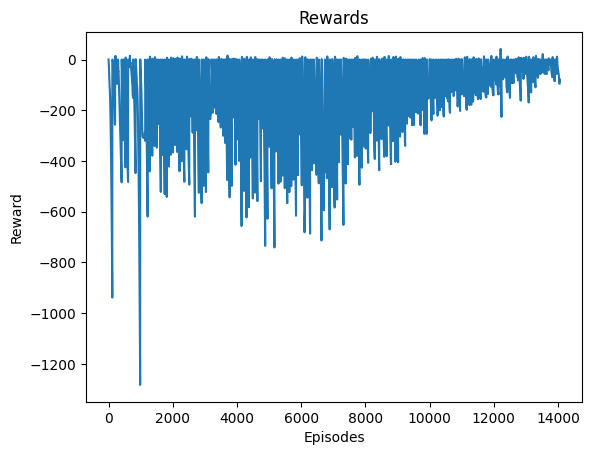

In [78]:
# Iterate over the rows of env.df and append them to df_rewards
for episode, reward in enumerate(agent.rewards()):
    new_row = ["10k", episode, reward]
    df_rewards.loc[len(df_rewards)] = new_row

# Save and plot reward
plt.title("Rewards")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.rewards())
plt.show()

##### Cumulative reward over time/step

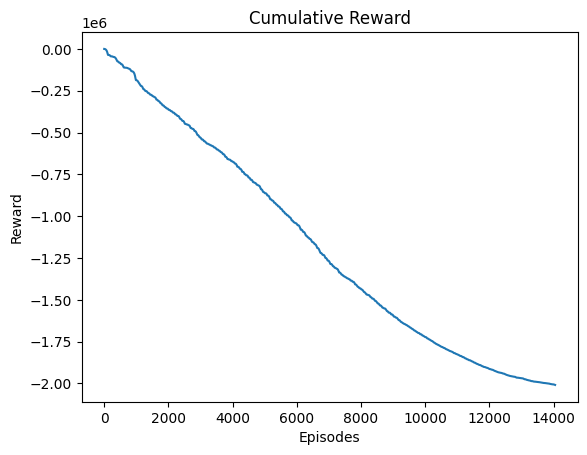

In [79]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.cumulative_reward())
plt.show()

#### WHY does the agent take an actions in the given state?

In [80]:
#we took 10% of experience replay samples as test data. The agent has not seen these yet
len(agent.df)

13945

In [81]:
#data is in tensor format
agent.df.head()

batch_state   
0  [[tensor(-0.7825), tensor(1.4643), tensor(-0.8...  \
1  [[tensor(-0.8264), tensor(1.3284), tensor(-0.8...   
2  [[tensor(-0.7825), tensor(1.4643), tensor(-0.8...   
3  [[tensor(-0.7638), tensor(1.5146), tensor(-0.8...   
4  [[tensor(-0.4545), tensor(1.9164), tensor(-1.0...   

                                    batch_next_state   
0  [[tensor(-0.7917), tensor(1.4381), tensor(-0.8...  \
1  [[tensor(-0.8346), tensor(1.2998), tensor(-0.8...   
2  [[tensor(-0.7917), tensor(1.4381), tensor(-0.8...   
3  [[tensor(-0.7733), tensor(1.4898), tensor(-0.8...   
4  [[tensor(-0.4645), tensor(1.9135), tensor(-1.0...   

                                        batch_action   
0  [tensor(-537.3337), tensor(-648.9282), tensor(...  \
1  [tensor(-604.6991), tensor(-111.6112), tensor(...   
2  [tensor(-537.3337), tensor(-22.7641), tensor(-...   
3  [tensor(-512.1841), tensor(-367.1778), tensor(...   
4  [tensor(-216.9687), tensor(-453.2974), tensor(...   

                                        batch_reward  
0  [tensor(1), tensor(1), tensor(1), tensor(2), t...  
1  [tensor(1), tensor(1), tensor(1), tensor(2), t...  
2  [tensor(1), tensor(2), tensor(1), tensor(2), t...  
3  [tensor(1), tensor(1), tensor(1), tensor(1), t...  
4  [tensor(1), tensor(1), tensor(1), tensor(2), t...

In [82]:
agent.df.batch_state.values #x coordinate landing pad, y coordinate landing pad, x linear velocity, y linear velocity, angle, angular velocity, left leg contact, right leg contact

array([tensor([[-7.8254e-01,  1.4643e+00, -8.6070e-01, -1.0579e+00,  4.2438e+00,
                 2.6162e+00,  0.0000e+00,  0.0000e+00],
               [-8.5073e-01,  1.2413e+00, -8.8109e-01, -1.2214e+00,  5.3705e+00,
                 2.9734e+00,  0.0000e+00,  0.0000e+00],
               [-6.0923e-01,  1.8000e+00, -1.0017e+00, -6.2165e-01,  2.2906e+00,
                 1.9290e+00,  0.0000e+00,  0.0000e+00],
               [-5.6507e-02,  1.4648e+00, -5.9226e-01,  3.3565e-01,  5.9548e-02,
                 1.1034e-01,  0.0000e+00,  0.0000e+00],
               [-7.0414e-01,  1.6493e+00, -9.1812e-01, -8.7950e-01,  3.2534e+00,
                 2.2976e+00,  0.0000e+00,  0.0000e+00],
               [ 6.3058e-44,  6.7262e-44,  7.5670e-44,  6.3058e-44,  6.8664e-44,
                 6.7262e-44,  1.1771e-43,  6.8664e-44],
               [-7.4444e-01,  1.5624e+00, -8.8071e-01, -9.7310e-01,  3.7324e+00,
                 2.4594e+00,  0.0000e+00,  0.0000e+00],
               [-3.7768e-01,  1.9153e+00,

In [83]:
states = np.concatenate(agent.df.batch_state.values)
states = torch.tensor(states)

In [84]:
# buffer sample for Deep Explainer
print(states)
len(states)

tensor([[-0.7825,  1.4643, -0.8607,  ...,  2.6162,  0.0000,  0.0000],
        [-0.8507,  1.2413, -0.8811,  ...,  2.9734,  0.0000,  0.0000],
        [-0.6092,  1.8000, -1.0017,  ...,  1.9290,  0.0000,  0.0000],
        ...,
        [ 0.3510,  0.5494,  0.5186,  ..., -0.1326,  0.0000,  0.0000],
        [-0.0996,  0.7371, -0.1609,  ..., -1.1842,  0.0000,  0.0000],
        [-0.2638,  0.1809, -0.4398,  ..., -2.8365,  0.0000,  0.0000]])


139450

In [85]:
#38401
training_states = states[0:1000] #38398
test_states = states[2000:2100] #38398:38401
print(test_states)
print(len(test_states))

tensor([[-9.3284e-02,  1.5192e+00, -6.3599e-01,  4.5198e-01,  8.9846e-02,
          9.6641e-02,  0.0000e+00,  0.0000e+00],
        [ 2.4736e-02,  1.4950e+00,  1.3532e-01,  1.2580e-01,  1.2134e-01,
          3.6840e-01,  0.0000e+00,  0.0000e+00],
        [ 3.4850e-01,  1.0837e+00,  1.1117e+00, -5.8360e-01, -7.1919e-01,
         -4.3539e-01,  0.0000e+00,  0.0000e+00],
        [ 4.5875e-02,  1.4839e+00,  2.1641e-01, -1.8141e-01,  2.6934e-01,
          2.7804e-02,  0.0000e+00,  0.0000e+00],
        [ 2.4116e-01,  2.7240e-01,  5.1114e-01, -1.3958e+00, -6.4054e-01,
          3.2024e-01,  0.0000e+00,  0.0000e+00],
        [-1.3241e-01,  1.5893e+00, -6.8830e-01,  5.6263e-01,  1.1956e-01,
          8.6388e-02,  0.0000e+00,  0.0000e+00],
        [ 3.5927e-02,  1.4494e+00,  6.0569e-01,  2.1862e-01, -4.0848e-02,
         -1.3563e-01,  0.0000e+00,  0.0000e+00],
        [ 3.5999e-01,  1.0707e+00,  1.1647e+00, -5.8700e-01, -7.4014e-01,
         -4.1899e-01,  0.0000e+00,  0.0000e+00],
        [-8.6642

DeepExplainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples. It's advisable to keep reasonable samples as background because too many samples will give more accurate results but will take a lot of time to compute SHAP values. Generally, 100 random samples are a good choice.

By integrating over many backgound samples [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [86]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, training_states) #training data

In [87]:
# compute shap values
shap_values = explainer.shap_values(test_states) #Returns approximate SHAP values for the model applied to the data given by X. 23.3s for 1000 training in test_states

if explain_row us called it returns a tuple of (row_values, row_expected_values, row_mask_shapes), where:
* row_values is an array of the attribution values for each sample, 
* row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), 
* row_mask_shapes is a list of all the input shapes (since the row_values is always flattened)

In [88]:
shap_values

[array([[ 1.44326248e+02,  5.06566429e+00,  5.34257393e+01,
         -2.63412228e+01,  7.21111084e+02,  2.43366928e+02,
         -8.54792063e-44, -9.66895940e-44],
        [ 1.85089493e+02,  6.49498272e+00,  1.04284760e+02,
         -1.45413284e+01,  7.14051392e+02,  2.15823425e+02,
         -8.54792063e-44, -9.66895940e-44],
        [ 2.96915924e+02,  3.07144852e+01,  1.68663208e+02,
          1.11219702e+01,  9.02496155e+02,  2.97290314e+02,
         -8.54792063e-44, -9.66895940e-44],
        [ 1.92390671e+02,  7.14405251e+00,  1.09631866e+02,
         -3.42770219e+00,  6.80870056e+02,  2.50343948e+02,
         -8.54792063e-44, -9.66895940e-44],
        [ 2.59842010e+02,  7.84928284e+01,  1.29066101e+02,
          4.05025864e+01,  8.84863464e+02,  2.20704132e+02,
         -8.54792063e-44, -9.66895940e-44],
        [ 1.30813232e+02,  9.40318048e-01,  4.99765244e+01,
         -3.03440609e+01,  7.14449341e+02,  2.44406509e+02,
         -8.54792063e-44, -9.66895940e-44],
        [ 1.8895

The [summary plot](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16) shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

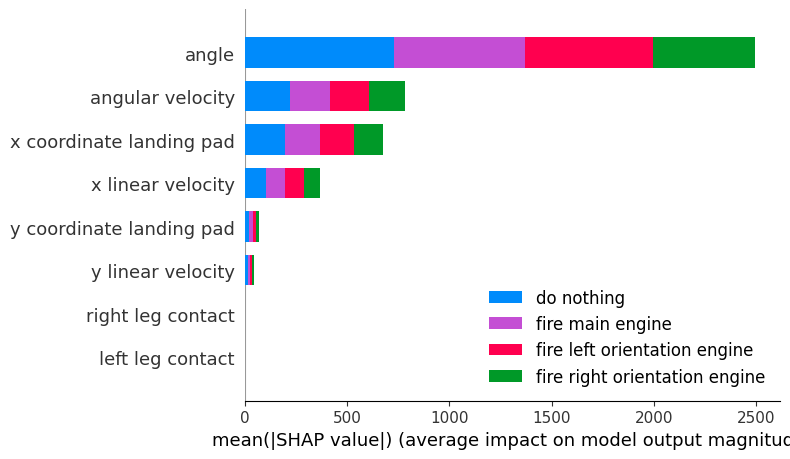

In [89]:

shap.summary_plot(shap_values[:], plot_type = 'bar', feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'], class_names=['do nothing', 'fire left orientation engine', 'fire main engine', 'fire right orientation engine']) #env.df.columns not the best

In [90]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'])

### 5,000 Capacity Size

In [91]:
env = gym.make("LunarLander-v2") #render_mode="human"
observation, info = env.reset(seed=42)
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

4
Discrete(4)
8
[ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]


In [92]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 5000 #memory capacity
m = 100 #memory sampling (100 samples and 10% for shap testing)
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate
agent = Dqn(s,a,g,c,l,t,m)

In [93]:
episodes = 200
for episode in range(episodes):
    observation, info = env.reset()
    done = False
    score = 0
    while not done:
        env.render()       
        action, qValues, transitionProbs = agent.update(score, observation)
        observation, reward, terminated, truncated, info = env.step(int(action))
        score += reward
        done = terminated or truncated
    print("episode: " + str(episode) + ", obs: " + str(observation) + ", action: " + str(int(action)) + ", score: " + str(score))

env.close()

episode: 0, obs: [-1.0109373   3.1230464  -2.307856    1.361954    0.76471907  0.24509403
  0.          0.        ], action: 2, score: -587.9470158299648
episode: 1, obs: [-1.0009689   0.22524527 -2.0617006  -2.1500547   1.6901217   0.17914858
  0.          0.        ], action: 2, score: -476.9191510192901
episode: 2, obs: [-0.35956225 -0.14499913  0.3652337  -0.11651213  0.3578378   1.2632188
  1.          1.        ], action: 0, score: -19.01302507654532
episode: 3, obs: [-0.3341925  -0.04042134  0.30142915 -0.12283549  3.0012782   2.7291694
  0.          0.        ], action: 0, score: -269.7710455494908
episode: 4, obs: [ 0.38850993 -0.03454198 -0.299019   -0.22624102 -0.35883442  3.0109687
  1.          0.        ], action: 0, score: -113.55124016012155
episode: 5, obs: [-3.0122891e-01 -7.8777403e-02 -7.6021469e-01 -1.2535040e-01
  2.4271315e-01 -4.1750759e-08  1.0000000e+00  0.0000000e+00], action: 0, score: -144.0217401305495
episode: 6, obs: [ 3.4222156e-01 -1.1654762e-01 -2.078

#### HOW did the agent performed?

##### Agent's final score

In [94]:
#Current sum of all values in the reward window
print(agent.score())

-430380.75105995475


##### Rewards at given time/step

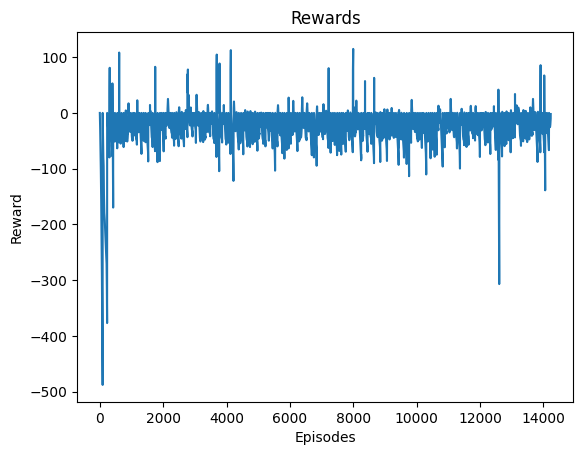

In [95]:
# Iterate over the rows of env.df and append them to df_rewards
for episode, reward in enumerate(agent.rewards()):
    new_row = ["5k", episode, reward]
    df_rewards.loc[len(df_rewards)] = new_row

# Save and plot reward
plt.title("Rewards")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.rewards())
plt.show()

##### Cumulative reward over time/step

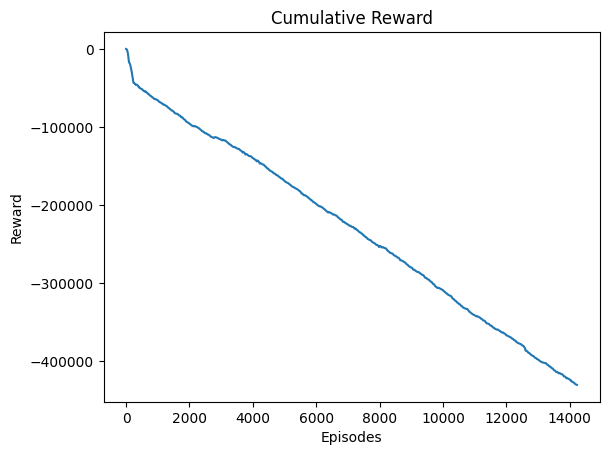

In [96]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.cumulative_reward())
plt.show()

#### WHY does the agent take an actions in the given state?

In [97]:
#we took 10% of experience replay samples as test data. The agent has not seen these yet
len(agent.df)

14134

In [98]:
#data is in tensor format
agent.df.head()

batch_state   
0  [[tensor(-0.1902), tensor(1.6967), tensor(-0.7...  \
1  [[tensor(-0.9215), tensor(3.0007), tensor(-2.1...   
2  [[tensor(-0.1124), tensor(1.5530), tensor(-0.6...   
3  [[tensor(-0.8788), tensor(2.9391), tensor(-2.0...   
4  [[tensor(-0.2538), tensor(1.8191), tensor(-0.8...   

                                    batch_next_state   
0  [[tensor(-0.1978), tensor(1.7109), tensor(-0.7...  \
1  [[tensor(-0.9434), tensor(3.0313), tensor(-2.1...   
2  [[tensor(-0.1189), tensor(1.5647), tensor(-0.6...   
3  [[tensor(-0.8999), tensor(2.9699), tensor(-2.1...   
4  [[tensor(-0.2621), tensor(1.8363), tensor(-0.8...   

                                        batch_action   
0  [tensor(-93.6472), tensor(-46.2734), tensor(-6...  \
1  [tensor(-466.5493), tensor(-338.4738), tensor(...   
2  [tensor(-54.8252), tensor(-11.6503), tensor(-5...   
3  [tensor(-446.3558), tensor(-480.6275), tensor(...   
4  [tensor(-126.9744), tensor(-19.4446), tensor(-...   

                                        batch_reward  
0  [tensor(2), tensor(2), tensor(2), tensor(2), t...  
1  [tensor(2), tensor(2), tensor(2), tensor(2), t...  
2  [tensor(2), tensor(2), tensor(2), tensor(2), t...  
3  [tensor(2), tensor(2), tensor(2), tensor(2), t...  
4  [tensor(2), tensor(2), tensor(2), tensor(2), t...

In [99]:
agent.df.batch_state.values #x coordinate landing pad, y coordinate landing pad, x linear velocity, y linear velocity, angle, angular velocity, left leg contact, right leg contact

array([tensor([[-0.1902,  1.6967, -0.7673,  0.6226,  0.1622,  0.1222,  0.0000,  0.0000],
               [-0.0996,  1.5299, -0.6335,  0.4753,  0.0951,  0.1057,  0.0000,  0.0000],
               [-0.1256,  1.5766, -0.6682,  0.5274,  0.1152,  0.0955,  0.0000,  0.0000],
               [-0.6747,  2.6170, -1.5987,  1.1856,  0.5540,  0.2446,  0.0000,  0.0000],
               [-0.8380,  2.8786, -1.9963,  1.3221,  0.6668,  0.2352,  0.0000,  0.0000],
               [-0.0111,  1.4189, -0.5632,  0.1830,  0.0124,  0.1206,  0.0000,  0.0000],
               [-0.2215,  1.7550, -0.8134,  0.6648,  0.1871,  0.1153,  0.0000,  0.0000],
               [-0.1463,  1.6148, -0.7018,  0.5717,  0.1277,  0.0844,  0.0000,  0.0000],
               [-0.2791,  1.8713, -0.8666,  0.7832,  0.2401,  0.1565,  0.0000,  0.0000],
               [-0.2538,  1.8191, -0.8236,  0.7502,  0.2163,  0.1607,  0.0000,  0.0000]]),
       tensor([[-0.9215,  3.0007, -2.1683,  1.3666,  0.7164,  0.2453,  0.0000,  0.0000],
               [-0.

In [100]:
states = np.concatenate(agent.df.batch_state.values)
states = torch.tensor(states)

In [101]:
# buffer sample for Deep Explainer
print(states)
len(states)

tensor([[-0.1902,  1.6967, -0.7673,  ...,  0.1222,  0.0000,  0.0000],
        [-0.0996,  1.5299, -0.6335,  ...,  0.1057,  0.0000,  0.0000],
        [-0.1256,  1.5766, -0.6682,  ...,  0.0955,  0.0000,  0.0000],
        ...,
        [-0.0065,  1.4200, -0.3268,  ...,  0.0733,  0.0000,  0.0000],
        [-0.1842,  0.7284, -0.3269,  ...,  0.0730,  0.0000,  0.0000],
        [-0.2047,  0.2837, -0.3509,  ...,  0.0783,  0.0000,  0.0000]])


141340

In [102]:
#38401
training_states = states[0:1000] #38398
test_states = states[2000:2100] #38398:38401
print(test_states)
print(len(test_states))

tensor([[-0.8562,  0.5928, -1.4628, -1.9245,  1.6221,  0.1512,  0.0000,  0.0000],
        [-0.1205,  1.8643, -0.5214,  0.5528,  0.2126,  0.4270,  0.0000,  0.0000],
        [-0.5860,  1.6805, -0.6733, -1.0120,  1.3144,  0.1970,  0.0000,  0.0000],
        [-0.3819,  0.1320, -0.5595, -1.7318,  0.4313,  0.1249,  0.0000,  0.0000],
        [-0.5270,  2.3592, -1.3472,  1.0711,  0.4427,  0.1994,  0.0000,  0.0000],
        [-0.4454,  2.0297, -0.6735, -0.4519,  1.1075,  0.1970,  0.0000,  0.0000],
        [-0.2372,  2.0639, -0.7227,  0.3400,  0.7520,  0.5233,  0.0000,  0.0000],
        [-0.6800,  1.3007, -0.6731, -1.3853,  1.4523,  0.1970,  0.0000,  0.0000],
        [-0.6330,  1.5053, -0.6732, -1.1986,  1.3834,  0.1970,  0.0000,  0.0000],
        [-0.0055,  1.4147, -0.5591,  0.1702,  0.0064,  0.1266,  0.0000,  0.0000],
        [-0.2490,  0.9008, -0.5596, -1.0917,  0.2815,  0.1249,  0.0000,  0.0000],
        [-0.0626,  1.4725, -0.6123,  0.3409,  0.0642,  0.0933,  0.0000,  0.0000],
        [-0.0996

DeepExplainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples. It's advisable to keep reasonable samples as background because too many samples will give more accurate results but will take a lot of time to compute SHAP values. Generally, 100 random samples are a good choice.

By integrating over many backgound samples [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [103]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, training_states) #training data

In [104]:
# compute shap values
shap_values = explainer.shap_values(test_states) #Returns approximate SHAP values for the model applied to the data given by X. 23.3s for 1000 training in test_states

if explain_row us called it returns a tuple of (row_values, row_expected_values, row_mask_shapes), where:
* row_values is an array of the attribution values for each sample, 
* row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), 
* row_mask_shapes is a list of all the input shapes (since the row_values is always flattened)

In [105]:
shap_values

[array([[-4.60927963e+00,  8.54523109e+19, -5.40763348e+19,
         -1.90247910e+02, -4.58989678e+19, -1.05035424e+00,
         -1.17551906e-07, -2.11282963e-06],
        [ 1.14518881e+00,  8.54523109e+19, -5.40763348e+19,
         -8.39666462e+00, -4.58989678e+19,  3.87356329e+00,
         -1.17551906e-07, -2.11282963e-06],
        [-2.49633145e+00,  8.54523109e+19, -5.40763348e+19,
         -1.23261032e+02, -4.58989678e+19, -2.32620016e-01,
         -1.17551906e-07, -2.11282963e-06],
        [-8.99436593e-01,  8.54523109e+19, -5.40763348e+19,
         -1.76097198e+02, -4.58989678e+19, -1.51999366e+00,
         -1.17551906e-07, -2.11282963e-06],
        [-2.03442121e+00,  8.54523109e+19, -5.40763348e+19,
          2.96442127e+01, -4.58989678e+19, -1.89320758e-01,
         -1.17551906e-07, -2.11282963e-06],
        [-1.39610326e+00,  8.54523109e+19, -5.40763348e+19,
         -8.21496353e+01, -4.58989678e+19, -2.32127115e-01,
         -1.17551906e-07, -2.11282963e-06],
        [ 2.3218

The [summary plot](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16) shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

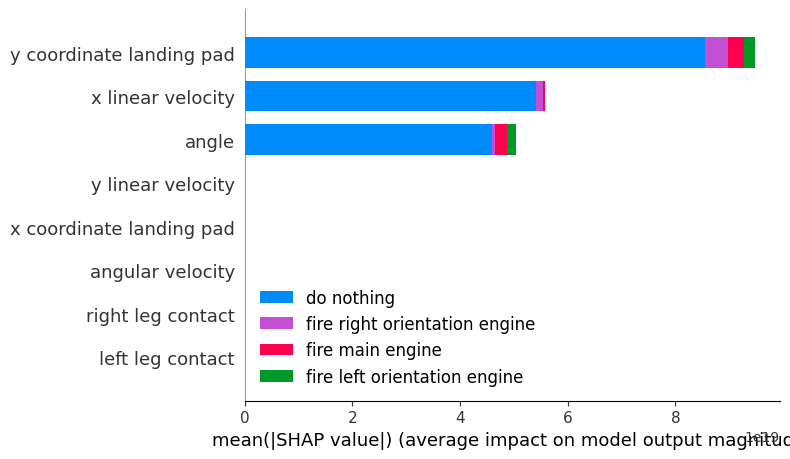

In [106]:

shap.summary_plot(shap_values[:], plot_type = 'bar', feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'], class_names=['do nothing', 'fire left orientation engine', 'fire main engine', 'fire right orientation engine']) #env.df.columns not the best

In [107]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'])

### 1,000 Capacity Size

In [108]:
env = gym.make("LunarLander-v2") #render_mode="human"
observation, info = env.reset(seed=42)
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

4
Discrete(4)
8
[ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]


In [109]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 1000 #memory capacity
m = 100 #memory sampling (100 samples and 10% for shap testing)
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate
agent = Dqn(s,a,g,c,l,t,m)

In [110]:
episodes = 200
for episode in range(episodes):
    observation, info = env.reset()
    done = False
    score = 0
    while not done:
        env.render()       
        action, qValues, transitionProbs = agent.update(score, observation)
        observation, reward, terminated, truncated, info = env.step(int(action))
        score += reward
        done = terminated or truncated
    print("episode: " + str(episode) + ", obs: " + str(observation) + ", action: " + str(int(action)) + ", score: " + str(score))

env.close()

episode: 0, obs: [-0.46068946  0.06772872 -1.3761982  -1.1278371   2.045093    6.1520815
  0.          1.        ], action: 1, score: -308.44983796963766
episode: 1, obs: [ 0.42772245 -0.09780335  1.4432595  -0.33782336 -0.40989757  1.6332089
  1.          1.        ], action: 0, score: -162.19584741129572


episode: 2, obs: [ 0.90528315  0.12509495  0.53736883 -0.9853076  -2.78369    -7.0557547
  0.          0.        ], action: 0, score: -488.49055870623295
episode: 3, obs: [ 0.32827845  0.08109206 -0.58317053 -0.23159306 -0.31099972  1.8822943
  1.          0.        ], action: 0, score: -97.17037888905762
episode: 4, obs: [ 0.21093225  0.00630592 -0.81238014 -0.6165156   0.12596998  3.1696365
  1.          1.        ], action: 0, score: -18.418424198567607
episode: 5, obs: [-0.42400655  0.01333803  0.6290834  -0.21119238  2.9107792   0.09406678
  0.          0.        ], action: 0, score: -274.31642047631664
episode: 6, obs: [-0.12325821 -0.03928209  0.02842688 -1.0865147   0.03981154 -6.3664618
  1.          0.        ], action: 0, score: -134.01958728647054
episode: 7, obs: [-2.5877601e-01 -7.1282662e-02 -1.2097373e+00 -2.9101723e-01
  3.4651470e-01 -9.6953023e-08  1.0000000e+00  1.0000000e+00], action: 0, score: -123.58895290851882
episode: 8, obs: [ 1.7555133e-01 -4.2242531e-02  2.

#### HOW did the agent performed?

##### Agent's final score

In [111]:
#Current sum of all values in the reward window
print(agent.score())

-1838763.987746999


##### Rewards at given time/step

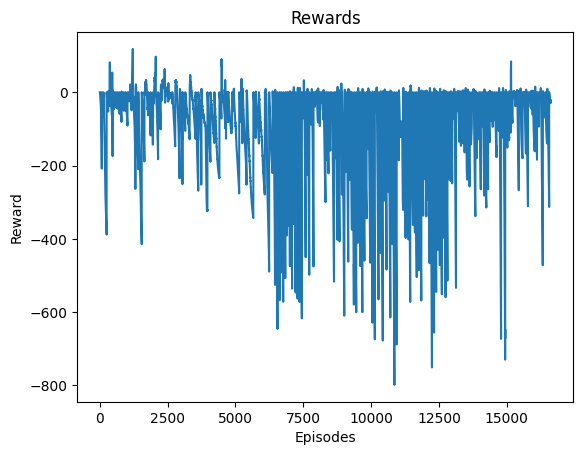

In [112]:
# Iterate over the rows of env.df and append them to df_rewards
for episode, reward in enumerate(agent.rewards()):
    new_row = ["1k", episode, reward]
    df_rewards.loc[len(df_rewards)] = new_row

# Save and plot reward
plt.title("Rewards")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.rewards())
plt.show()

##### Cumulative reward over time/step

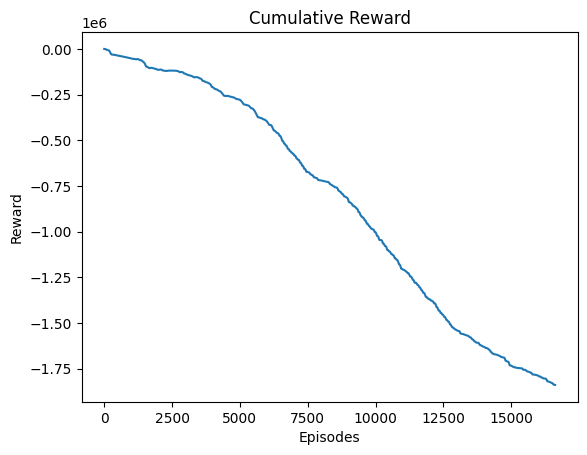

In [113]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.cumulative_reward())
plt.show()

#### WHY does the agent take an actions in the given state?

In [114]:
#we took 10% of experience replay samples as test data. The agent has not seen these yet
len(agent.df)

16519

In [115]:
#data is in tensor format
agent.df.head()

batch_state   
0  [[tensor(0.0628), tensor(1.3277), tensor(0.705...  \
1  [[tensor(-0.1878), tensor(1.2054), tensor(-0.5...   
2  [[tensor(0.1744), tensor(1.0600), tensor(0.705...   
3  [[tensor(-0.3705), tensor(0.4699), tensor(-0.7...   
4  [[tensor(-0.0221), tensor(1.4227), tensor(-0.5...   

                                    batch_next_state   
0  [[tensor(0.0698), tensor(1.3155), tensor(0.705...  \
1  [[tensor(-0.1933), tensor(1.1888), tensor(-0.5...   
2  [[tensor(0.1814), tensor(1.0382), tensor(0.705...   
3  [[tensor(-0.3779), tensor(0.4348), tensor(-0.7...   
4  [[tensor(-0.0276), tensor(1.4242), tensor(-0.5...   

                                        batch_action   
0  [tensor(-9.3915), tensor(-1.2368), tensor(-65....  \
1  [tensor(-32.9940), tensor(-5.1527), tensor(-39...   
2  [tensor(-26.9125), tensor(-21.4626), tensor(-6...   
3  [tensor(-136.3391), tensor(-183.1281), tensor(...   
4  [tensor(-0.8229), tensor(-18.8321), tensor(-25...   

                                        batch_reward  
0  [tensor(0), tensor(0), tensor(1), tensor(0), t...  
1  [tensor(0), tensor(0), tensor(0), tensor(1), t...  
2  [tensor(0), tensor(0), tensor(0), tensor(1), t...  
3  [tensor(1), tensor(1), tensor(1), tensor(1), t...  
4  [tensor(0), tensor(0), tensor(0), tensor(0), t...

In [116]:
agent.df.batch_state.values #x coordinate landing pad, y coordinate landing pad, x linear velocity, y linear velocity, angle, angular velocity, left leg contact, right leg contact

array([tensor([[ 0.0628,  1.3277,  0.7056, -0.5176, -0.0713, -0.1579,  0.0000,  0.0000],
               [-0.0276,  1.4242, -0.5584,  0.0645,  0.0314,  0.1251,  0.0000,  0.0000],
               [-0.2749,  0.8923, -0.6524, -1.1316,  0.4197,  0.5337,  0.0000,  0.0000],
               [-0.1712,  1.2514, -0.5585, -0.6299,  0.1936,  0.1246,  0.0000,  0.0000],
               [ 0.0698,  1.3155,  0.7056, -0.5443, -0.0792, -0.1579,  0.0000,  0.0000],
               [-0.0386,  1.4253, -0.5584,  0.0112,  0.0439,  0.1250,  0.0000,  0.0000],
               [-0.1160,  1.3659, -0.5586, -0.3622,  0.1313,  0.1247,  0.0000,  0.0000],
               [ 0.0558,  1.3394,  0.7056, -0.4910, -0.0634, -0.1579,  0.0000,  0.0000],
               [-0.3277,  0.6666, -0.7227, -1.3730,  0.7100,  0.8835,  0.0000,  0.0000],
               [-0.3705,  0.4699, -0.7610, -1.5638,  1.0242,  1.1574,  0.0000,  0.0000]]),
       tensor([[-0.1878,  1.2054, -0.5585, -0.7099,  0.2123,  0.1246,  0.0000,  0.0000],
               [-0.

In [117]:
states = np.concatenate(agent.df.batch_state.values)
states = torch.tensor(states)

In [118]:
# buffer sample for Deep Explainer
print(states)
len(states)

tensor([[ 0.0628,  1.3277,  0.7056,  ..., -0.1579,  0.0000,  0.0000],
        [-0.0276,  1.4242, -0.5584,  ...,  0.1251,  0.0000,  0.0000],
        [-0.2749,  0.8923, -0.6524,  ...,  0.5337,  0.0000,  0.0000],
        ...,
        [ 0.0722,  1.1716,  0.2293,  ...,  0.5613,  0.0000,  0.0000],
        [ 0.0438,  0.9604,  0.1847,  ..., -0.0412,  0.0000,  0.0000],
        [ 0.2260,  1.2208,  0.3322,  ...,  1.6197,  0.0000,  0.0000]])


165190

In [119]:
#38401
training_states = states[0:1000] #38398
test_states = states[2000:2100] #38398:38401
print(test_states)
print(len(test_states))

tensor([[ 0.1231,  1.1748,  0.5660, -0.7572, -0.1394, -0.1264,  0.0000,  0.0000],
        [ 0.0351,  1.4202,  0.5424,  0.0760, -0.0343, -0.0647,  0.0000,  0.0000],
        [-0.1381,  1.3274, -0.5587, -0.4689,  0.1563,  0.1247,  0.0000,  0.0000],
        [ 0.7282,  0.8568,  0.8738, -1.3566, -2.4647, -0.2800,  0.0000,  0.0000],
        [ 0.0447,  1.3586,  0.5658, -0.3838, -0.0508, -0.1266,  0.0000,  0.0000],
        [ 0.1934,  1.6437,  0.6901,  0.3210, -0.2331, -0.4481,  0.0000,  0.0000],
        [ 0.1867,  1.6364,  0.6808,  0.3496, -0.2106, -0.4087,  0.0000,  0.0000],
        [ 0.2001,  1.6504,  0.6989,  0.2933, -0.2573, -0.4842,  0.0000,  0.0000],
        [ 0.3111,  1.6744,  0.8320, -0.1607, -0.8879, -1.1606,  0.0000,  0.0000],
        [-0.0994,  1.3885, -0.5586, -0.2822,  0.1126,  0.1248,  0.0000,  0.0000],
        [-0.0386,  1.4253, -0.5584,  0.0112,  0.0439,  0.1250,  0.0000,  0.0000],
        [-0.4470,  0.0912, -0.7912, -1.8001,  1.7573,  2.1545,  0.0000,  1.0000],
        [ 0.5186

DeepExplainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples. It's advisable to keep reasonable samples as background because too many samples will give more accurate results but will take a lot of time to compute SHAP values. Generally, 100 random samples are a good choice.

By integrating over many backgound samples [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [120]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, training_states) #training data

In [121]:
# compute shap values
shap_values = explainer.shap_values(test_states) #Returns approximate SHAP values for the model applied to the data given by X. 23.3s for 1000 training in test_states

if explain_row us called it returns a tuple of (row_values, row_expected_values, row_mask_shapes), where:
* row_values is an array of the attribution values for each sample, 
* row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), 
* row_mask_shapes is a list of all the input shapes (since the row_values is always flattened)

In [122]:
shap_values

[array([[ 1.64636459e+01, -1.10244799e+01,  1.08735970e+02,
          2.38678989e+01,  1.12611653e+22,  4.23056124e+22,
         -2.15653196e-01, -2.72504060e+21],
        [ 8.34229374e+00, -2.53878117e+01,  1.04858032e+02,
          2.97803284e+02,  1.12611653e+22,  4.23056124e+22,
         -2.15653196e-01, -2.72504060e+21],
        [-7.64124203e+00, -1.99516182e+01, -7.59410706e+01,
          1.18648338e+02,  1.12611653e+22,  4.23056124e+22,
         -2.15653196e-01, -2.72504060e+21],
        [ 7.23192520e+01,  7.59072399e+00,  1.59266861e+02,
         -1.73172928e+02,  1.12611653e+22,  4.23056124e+22,
         -2.15653196e-01, -2.72504060e+21],
        [ 9.23244762e+00, -2.17828693e+01,  1.08695137e+02,
          1.46630630e+02,  1.12611653e+22,  4.23056124e+22,
         -2.15653196e-01, -2.72504060e+21],
        [ 2.29536209e+01, -3.84717979e+01,  1.29113159e+02,
          3.78340088e+02,  1.12611653e+22,  4.23056124e+22,
         -2.15653196e-01, -2.72504060e+21],
        [ 2.2336

The [summary plot](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16) shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

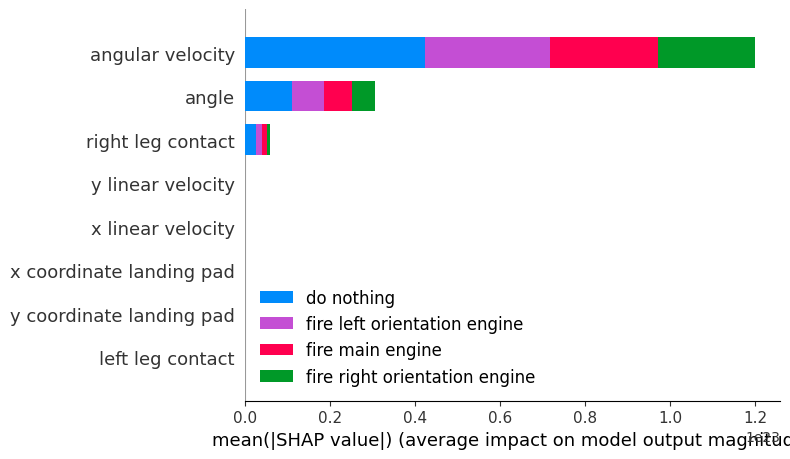

In [123]:

shap.summary_plot(shap_values[:], plot_type = 'bar', feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'], class_names=['do nothing', 'fire left orientation engine', 'fire main engine', 'fire right orientation engine']) #env.df.columns not the best

In [124]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'])

### 500 Capacity Size

In [125]:
env = gym.make("LunarLander-v2") #render_mode="human"
observation, info = env.reset(seed=42)
print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

4
Discrete(4)
8
[ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]


In [126]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 500 #memory capacity
m = 100 #memory sampling (100 samples and 10% for shap testing)
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate
agent = Dqn(s,a,g,c,l,t,m)

In [127]:
episodes = 200
for episode in range(episodes):
    observation, info = env.reset()
    done = False
    score = 0
    while not done:
        env.render()       
        action, qValues, transitionProbs = agent.update(score, observation)
        observation, reward, terminated, truncated, info = env.step(int(action))
        score += reward
        done = terminated or truncated
    print("episode: " + str(episode) + ", obs: " + str(observation) + ", action: " + str(int(action)) + ", score: " + str(score))

env.close()

episode: 0, obs: [ 0.46887177  0.07824677  2.3135848  -0.5178558  -2.5750942  -0.00953116
  0.          0.        ], action: 1, score: -468.61170683707854
episode: 1, obs: [-2.4960442e-01 -1.7053747e-03 -9.0062845e-01 -2.0582691e-01
 -3.5798051e+00  8.9163888e-01  0.0000000e+00  0.0000000e+00], action: 0, score: -462.7029587747507


episode: 2, obs: [ 0.52223825  0.05357202  0.30964202  0.03011503 -3.8128712  -0.9390665
  0.          0.        ], action: 0, score: -529.8398937548457
episode: 3, obs: [ 1.0096953   2.249853    2.759706    0.5705683  -1.1796176   0.06554247
  0.          0.        ], action: 1, score: -585.7943643290942
episode: 4, obs: [ 1.3132954e-01 -6.4118290e-03 -1.4671703e-01 -8.0109078e-01
  3.1712761e+00  7.3469572e+00  0.0000000e+00  0.0000000e+00], action: 2, score: -419.0904092368022
episode: 5, obs: [-0.6030747  -0.15618233 -1.842282   -0.09434023  2.0065095  -2.4896915
  0.          1.        ], action: 2, score: -491.9578756192075
episode: 6, obs: [ 0.18303232 -0.01934383 -0.4815689  -1.0521897   0.06904059  6.916053
  1.          1.        ], action: 0, score: -132.6359220624448
episode: 7, obs: [-0.06066256  0.00650941  0.10643417  0.02641621 -2.0067382  -0.34116808
  1.          0.        ], action: 0, score: -245.7526139681109
episode: 8, obs: [ 0.5636673  -0.02773968 -0.01204533 -0

#### HOW did the agent performed?

##### Agent's final score

In [128]:
#Current sum of all values in the reward window
print(agent.score())

-2415004.7720847214


##### Rewards at given time/step

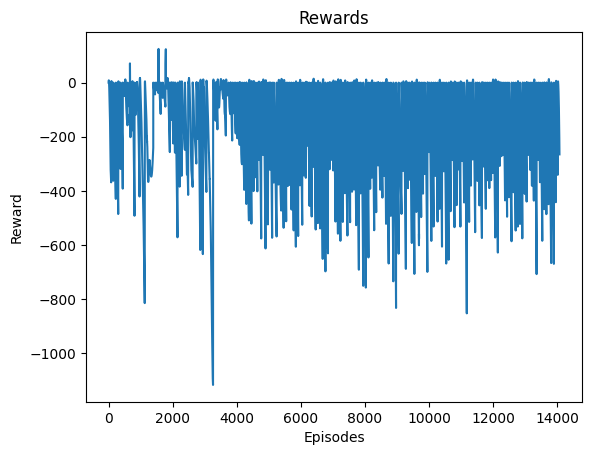

In [129]:
# Iterate over the rows of env.df and append them to df_rewards
for episode, reward in enumerate(agent.rewards()):
    new_row = ["500", episode, reward]
    df_rewards.loc[len(df_rewards)] = new_row

# Save and plot reward
plt.title("Rewards")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.rewards())
plt.show()

##### Cumulative reward over time/step

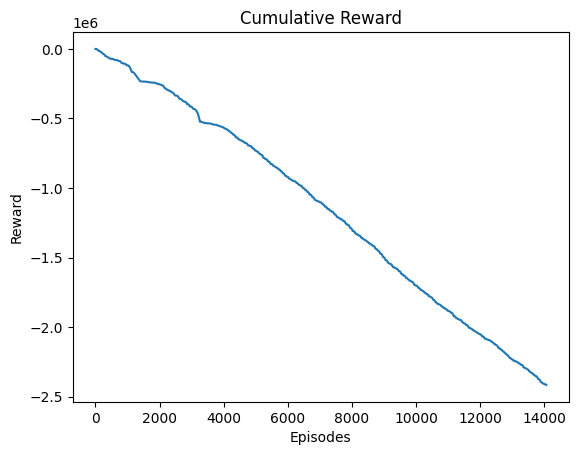

In [130]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(agent.cumulative_reward())
plt.show()

#### WHY does the agent take an actions in the given state?

In [131]:
#we took 10% of experience replay samples as test data. The agent has not seen these yet
len(agent.df)

13969

In [132]:
#data is in tensor format
agent.df.head()

batch_state   
0  [[tensor(0.1873), tensor(0.5841), tensor(1.796...  \
1  [[tensor(-0.1391), tensor(1.2061), tensor(-0.0...   
2  [[tensor(-0.0055), tensor(1.4147), tensor(-0.5...   
3  [[tensor(0.2056), tensor(0.5534), tensor(1.802...   
4  [[tensor(0.0632), tensor(0.7807), tensor(1.635...   

                                    batch_next_state   
0  [[tensor(0.2056), tensor(0.5534), tensor(1.802...  \
1  [[tensor(-0.1391), tensor(1.1943), tensor(0.03...   
2  [[tensor(-0.0110), tensor(1.4180), tensor(-0.5...   
3  [[tensor(0.2239), tensor(0.5222), tensor(1.807...   
4  [[tensor(0.0802), tensor(0.7551), tensor(1.674...   

                                        batch_action   
0  [tensor(-328.2908), tensor(-63.4139), tensor(-...  \
1  [tensor(-68.0890), tensor(-63.4139), tensor(7....   
2  [tensor(0.), tensor(-16.2297), tensor(-56.5711...   
3  [tensor(-331.1286), tensor(-322.2886), tensor(...   
4  [tensor(-289.1165), tensor(-365.2135), tensor(...   

                                        batch_reward  
0  [tensor(1), tensor(2), tensor(3), tensor(1), t...  
1  [tensor(2), tensor(2), tensor(3), tensor(2), t...  
2  [tensor(3), tensor(3), tensor(2), tensor(1), t...  
3  [tensor(1), tensor(1), tensor(2), tensor(2), t...  
4  [tensor(2), tensor(1), tensor(3), tensor(2), t...

In [133]:
agent.df.batch_state.values #x coordinate landing pad, y coordinate landing pad, x linear velocity, y linear velocity, angle, angular velocity, left leg contact, right leg contact

array([tensor([[ 1.8730e-01,  5.8405e-01,  1.7969e+00, -1.3555e+00, -2.3069e+00,
                -6.9104e-01,  0.0000e+00,  0.0000e+00],
               [-1.3832e-01,  1.2182e+00, -9.0231e-02, -5.4559e-01, -8.3452e-01,
                -9.2962e-01,  0.0000e+00,  0.0000e+00],
               [-8.1972e-02,  1.3415e+00, -4.6827e-01, -3.9438e-01, -1.1306e-01,
                -4.3342e-01,  0.0000e+00,  0.0000e+00],
               [ 4.2908e-01,  1.4381e-01,  1.8940e+00, -1.6508e+00, -2.5715e+00,
                -1.4194e-01,  0.0000e+00,  0.0000e+00],
               [-7.6375e-02,  1.0038e+00,  8.1044e-01, -7.4591e-01, -1.5368e+00,
                -8.6731e-01,  0.0000e+00,  0.0000e+00],
               [-3.7043e-02,  1.4252e+00, -4.9984e-01,  1.0871e-02,  3.8279e-03,
                -1.0930e-01,  0.0000e+00,  0.0000e+00],
               [ 1.5940e-02,  8.5121e-01,  1.4339e+00, -9.9307e-01, -1.8876e+00,
                -8.9389e-01,  0.0000e+00,  0.0000e+00],
               [-7.0275e-02,  1.4102e+00,

In [134]:
states = np.concatenate(agent.df.batch_state.values)
states = torch.tensor(states)

In [135]:
# buffer sample for Deep Explainer
print(states)
len(states)

tensor([[ 0.1873,  0.5841,  1.7969,  ..., -0.6910,  0.0000,  0.0000],
        [-0.1383,  1.2182, -0.0902,  ..., -0.9296,  0.0000,  0.0000],
        [-0.0820,  1.3415, -0.4683,  ..., -0.4334,  0.0000,  0.0000],
        ...,
        [ 0.0071,  1.4035,  0.1626,  ...,  0.0751,  0.0000,  0.0000],
        [ 0.2379,  0.6286,  0.4298,  ...,  1.4016,  0.0000,  0.0000],
        [-0.0097,  0.3066, -0.0039,  ...,  2.3610,  0.0000,  0.0000]])


139690

In [136]:
#38401
training_states = states[0:1000] #38398
test_states = states[2000:2100] #38398:38401
print(test_states)
print(len(test_states))

tensor([[-1.6003e-01,  1.0557e+00, -3.0795e-01, -9.5460e-01, -9.1537e-01,
         -1.2070e+00,  0.0000e+00,  0.0000e+00],
        [-2.0226e-01,  6.9687e-01, -2.9066e-01, -1.3733e+00, -1.9277e+00,
         -1.5534e+00,  0.0000e+00,  0.0000e+00],
        [ 5.0404e-02,  1.4512e+00,  5.2061e-01,  2.6171e-02, -1.5407e-01,
         -4.7350e-01,  0.0000e+00,  0.0000e+00],
        [-5.8464e-02,  9.6940e-01,  9.3295e-01, -8.0492e-01, -1.6224e+00,
         -8.5796e-01,  0.0000e+00,  0.0000e+00],
        [ 2.7941e-01,  1.0711e+00,  6.9975e-01, -9.6705e-01, -1.9639e+00,
         -1.1298e+00,  0.0000e+00,  0.0000e+00],
        [-2.3245e-01,  2.8405e-01, -3.2681e-01, -1.7144e+00, -2.9624e+00,
         -1.7747e+00,  0.0000e+00,  0.0000e+00],
        [-1.8842e-01,  8.3947e-01, -2.8694e-01, -1.2331e+00, -1.5418e+00,
         -1.5026e+00,  0.0000e+00,  0.0000e+00],
        [ 2.0908e-01,  1.6370e+00,  1.1052e+00,  5.8115e-01, -6.1536e-01,
         -3.5527e-01,  0.0000e+00,  0.0000e+00],
        [-1.9688

DeepExplainer is designed for deep learning models created using Keras, TensorFlow, and PyTorch. It’s an enhanced version of the DeepLIFT algorithm where we measure conditional expectations of SHAP values based on a number of background samples. It's advisable to keep reasonable samples as background because too many samples will give more accurate results but will take a lot of time to compute SHAP values. Generally, 100 random samples are a good choice.

By integrating over many backgound samples [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

the complexity of the method scales linearly with the number of background data samples. Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly 1/sqrt(N) for N background data samples. So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [137]:
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, training_states) #training data

In [138]:
# compute shap values
shap_values = explainer.shap_values(test_states) #Returns approximate SHAP values for the model applied to the data given by X. 23.3s for 1000 training in test_states

if explain_row us called it returns a tuple of (row_values, row_expected_values, row_mask_shapes), where:
* row_values is an array of the attribution values for each sample, 
* row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), 
* row_mask_shapes is a list of all the input shapes (since the row_values is always flattened)

In [139]:
shap_values

[array([[-1.09447699e+01,  4.08015002e+22,  6.91889095e+00,
         -2.83555695e+02,  1.48616409e+01, -1.21437425e+21,
          2.53698478e+17,  3.62844167e+31],
        [-1.49432745e+01,  4.08015002e+22,  6.84124422e+00,
         -6.78094788e+02,  2.64176086e+02, -1.21437425e+21,
          2.53698478e+17,  3.62844167e+31],
        [ 8.98213196e+00,  4.08015002e+22,  3.19817376e+00,
          6.40563904e+02, -1.72623840e+02, -1.21437425e+21,
          2.53698478e+17,  3.62844167e+31],
        [-1.32706308e+00,  4.08015002e+22,  1.34654593e+00,
         -1.42520645e+02,  1.88972412e+02, -1.21437425e+21,
          2.53698478e+17,  3.62844167e+31],
        [ 3.06677361e+01,  4.08015002e+22,  2.39373708e+00,
         -2.95285706e+02,  2.73090454e+02, -1.21437425e+21,
          2.53698478e+17,  3.62844167e+31],
        [-1.78024216e+01,  4.08015002e+22,  7.00356388e+00,
         -9.99501892e+02,  5.18993347e+02, -1.21437425e+21,
          2.53698478e+17,  3.62844167e+31],
        [-1.3632

The [summary plot](https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16) shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

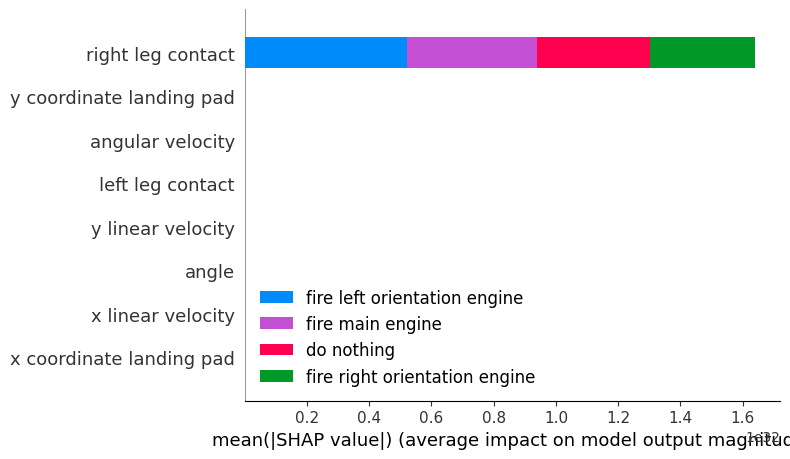

In [140]:

shap.summary_plot(shap_values[:], plot_type = 'bar', feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'], class_names=['do nothing', 'fire left orientation engine', 'fire main engine', 'fire right orientation engine']) #env.df.columns not the best

In [141]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names = ['x coordinate landing pad', 'y coordinate landing pad', 'x linear velocity', 'y linear velocity', 'angle', 'angular velocity', 'left leg contact', 'right leg contact'])

## ANOVA

In [142]:
df_rewards.tail()

capacity  episodes      reward
132029      500     14064 -214.916884
132030      500     14065 -226.578321
132031      500     14066 -238.640911
132032      500     14067 -251.678199
132033      500     14068 -265.301645

In [143]:
x = datetime.datetime.now()
file_name = str(x.year) + "_" + str(x.month) + "_" + str(x.day) + "_" + str(x.strftime("%H")) + "_" + str(x.strftime("%M")) + "_" + str(x.strftime("%S")) + "_lunar_lander" + ".csv"
df_rewards.to_csv(file_name, index=False, encoding='utf-8')

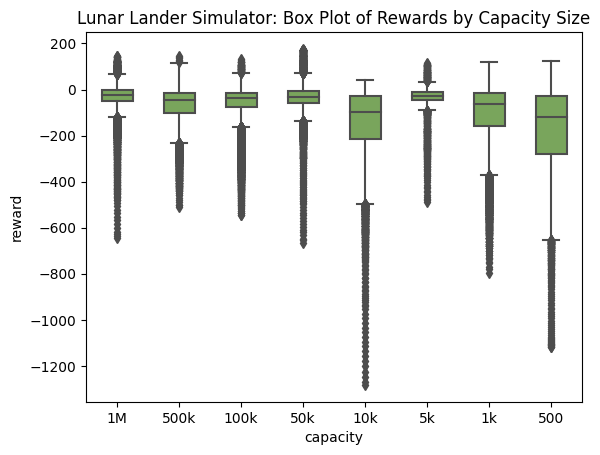

In [144]:
ax = sns.boxplot(x='capacity', y='reward', data=df_rewards, color='#77B150', width=0.5).set(title='Lunar Lander Simulator: Box Plot of Rewards by Capacity Size')
plt.show()

In [145]:
# Perform ANOVA and obtain group means
model = ols('reward ~ C(capacity)', data=df_rewards).fit()

In [146]:
group_means = df_rewards.groupby('capacity')['reward'].mean()
print(group_means)

capacity
100k    -63.282395
10k    -143.031899
1M      -33.303393
1k     -110.642276
500    -171.654330
500k    -69.130536
50k     -37.242960
5k      -30.236107
Name: reward, dtype: float64


In [147]:
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                   sum_sq        df            F  PR(>F)
C(capacity)  3.186924e+08       7.0  4518.403655     0.0
Residual     1.330295e+09  132026.0          NaN     NaN


p-value (PR(>F)): 0.0 indicates that the p-value is extremely small (below the typical threshold of 0.05), suggesting strong evidence to reject the null hypothesis. This means that there is a significant difference between at least two group means of the "capacity" variable.

 "capacity" variable has a significant effect on the "reward" variable. F-statistic is large, further supporting the conclusion that the means of the different "capacity" groups are significantly different from each other.

In [148]:
# Perform Tukey's HSD test
mc_results = mc.MultiComparison(df_rewards['reward'], df_rewards['capacity'])
tukey_results = mc_results.tukeyhsd()

In [149]:
# Print the results
print(tukey_results)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
  100k    10k  -79.7495    0.0  -83.3814  -76.1176   True
  100k     1M    29.979    0.0   26.6821   33.2759   True
  100k     1k  -47.3599    0.0  -50.8484  -43.8714   True
  100k    500 -108.3719    0.0 -112.0022 -104.7416   True
  100k   500k   -5.8481    0.0   -9.4677   -2.2286   True
  100k    50k   26.0394    0.0   22.7832   29.2956   True
  100k     5k   33.0463    0.0   29.4265   36.6661   True
   10k     1M  109.7285    0.0  106.4331  113.0239   True
   10k     1k   32.3896    0.0   28.9025   35.8767   True
   10k    500  -28.6224    0.0  -32.2514  -24.9935   True
   10k   500k   73.9014    0.0   70.2832   77.5195   True
   10k    50k  105.7889    0.0  102.5343  109.0436   True
   10k     5k  112.7958    0.0  109.1774  116.4142   True
    1M     1k  -77.3389    0.0  -80.4756  -74.2022   True
    1M    500 